<h1 style='color:orange; font-weight:bold; text-align:center'>Exploring Sentiments in Customer Product Reviews on Tokopedia</h1>

## **1 Introduction**

- Background 
- Problem stetement
- Objective

The dataset for my project was taken from [PRDECT-ID](https://www.kaggle.com/datasets/jocelyndumlao/prdect-id-indonesian-emotion-classification), an emotion classification project in Indonesian, on Kaggle. Based on the decription, the dataset was collected from Tokopedia, an e-commerce in Indonesia. The reviews have been labeled by a group of annotator with a guideline reviewed by a clinical psychologist but the numeber of annotators, including the raw dataset from all annotators not included. This inclusion can actually provide an understanding of the inter-rater reliability which is crucial for natural language processing project.

## **2 Data Preparation**
In this chapter, we will conduct data preparation, covering data overview and data cleanliness. Data overview is concerned with getting general insights about the dataset such as the number of features, the number of observations, data types, missing value check, duplicate check, and number of unique values. These checks can be done all at once by creating a function. Moreover, data cleanliness is a follow-up step based on the data overview. For example, if missing values are detected during the initial inspection, this sub-section will further investigate the patterns or mechanisms of missingness so that an appropriate action, e.g., data removal or imputation, can be carefully done.

In [137]:
# GENERAL
import pandas as pd
import numpy as np

# DATA VISUALIZATION
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from wordcloud import WordCloud
plt.style.use('ggplot')

# STATISTICAL TEST
import phik
from scipy.stats import kstest
from scipy.stats import mannwhitneyu 
from scipy.stats import chi2_contingency 
from sklearn.utils import resample

# FEATURE EXTRACTION
import nltk
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.text import ConcordanceIndex
from sklearn.feature_extraction.text import CountVectorizer

In [52]:
# load dataset
df = pd.read_csv('../data/PRDECT-ID Dataset.csv')

In [53]:
# function to inspect dataframe
def inspect_dataframe(df):
    summary = {
        'ColumnName': df.columns.values.tolist(),
        'Nrow': df.shape[0],
        'DataType': df.dtypes.values.tolist(),
        'NAPct': (df.isna().mean()*100).round(2).tolist(),
        'DuplicatePct': (df.duplicated().sum()/len(df)*100).round(2),
        'UniqueValues': df.nunique().tolist(),
        'Sample': [df[col].unique() for col in df.columns]
    }
    return pd.DataFrame(summary)

**Comment**: The function `inspect_dataframe()` serves to perform basic inspection of the dataframe passed to the function. This function will provide information such as column names, number of observations, data types, rates of missing values, rates of duplicates, number of unique values, and some unique samples drawn from the dataframe. And since the function has not included the count of column names (even though we can count directly from the number of rows in the output), we will add this information independently using `df.shape`, giving more details on the number of columns, including the target variable, namely `Sentiment`, and their data types.

In [54]:
# inspect dataframe
print(f'The dataframe contains {df.shape[0]} rows and {df.shape[1]} cols')
print(f"- {len(df.select_dtypes(include='number').columns)} are numeric cols")
print(f"- {len(df.select_dtypes(include='O').columns)} are object cols")
inspect_dataframe(df)

The dataframe contains 5400 rows and 11 cols
- 5 are numeric cols
- 6 are object cols


ColumnName  Nrow DataType  NAPct  DuplicatePct  UniqueValues  \
0          Category  5400   object    0.0          0.13            29   
1      Product Name  5400   object    0.0          0.13          1308   
2          Location  5400   object    0.0          0.13            61   
3             Price  5400    int64    0.0          0.13           555   
4    Overall Rating  5400  float64    0.0          0.13            10   
5       Number Sold  5400    int64    0.0          0.13          1043   
6      Total Review  5400    int64    0.0          0.13           958   
7   Customer Rating  5400    int64    0.0          0.13             5   
8   Customer Review  5400   object    0.0          0.13          5305   
9         Sentiment  5400   object    0.0          0.13             2   
10          Emotion  5400   object    0.0          0.13             5   

                                               Sample  
0   [Computers and Laptops, Toys and Hobbies, Food...  
1   [Wireless Keyboard i8 Mini TouchPad Mouse 2.4G...  
2   [Jakarta Utara, Kota Tangerang Selatan, Jakart...  
3   [53500, 72000, 213000, 55000, 85000, 136500, 1...  
4   [4.9, 5.0, 4.7, 4.8, 4.3, 4.6, 4.4, 4.5, 4.2, ...  
5   [5449, 2359, 12300, 2030, 1339, 1201, 1630, 27...  
6   [2369, 1044, 3573, 672, 718, 632, 777, 882, 82...  
7                                     [5, 1, 3, 2, 4]  
8   [Alhamdulillah berfungsi dengan baik. Packagin...  
9                                [Positive, Negative]  
10                [Happy, Sadness, Anger, Love, Fear]

**Comment**
- The dataset comprises of 11 columns in which 5 columns are numerical and 6 variables are categorical. In addition to the number of columns, the output above also provides information about the number of observations (*N* = 5,400). With this amount of data, the computation for both data analysis and predictive modeling should not be a big deal.
- The dataset does not contain any missing values so no further actions will be necessary to check the mechanisms and determine an appropriate action for handling the issue. On the other hand, a small amount of duplicates is present. For this reason, we will remove the duplicates before carrying out an analysis. Just for the record, the function `inspect_dataframe` created above checked duplicates in all columns, meaning no subset of datset was set. Due to not using subset, we will need to double check the duplicates again, especially for predictive modeling. When the focus is on column customer review and sentiment, duplicates may emerge since other columns are not considered.
- Even though my main concern is to model sentiment based on the customer reviews, other columns will be still used for data analysis to assist sellers in finding out how users feel about their products and services.
- However, before moving on, we will replace all white spaces between words in columns to make the analysis and predictive modeling more conveninent.

In [55]:
# change column names
df.columns = df.columns.str.replace(' ', '')

**Comment**: White spaces in dataframe columns were removed to prevent en error. For example, while calling a column with square brackets, e.g., `df['Column Name']`, has no problem, an error will appear when function calling is done by using a period, e.g., `df.'Column Name'`. Such function call can only be performed when no spaces are present.

In [56]:
# check duplicates
duplicates = df[df.duplicated(keep=False)].sort_values(by='CustomerReview')
print(f'Total duplicates: {len(duplicates)}')
display(duplicates.iloc[:5, :])

Total duplicates: 13


Category                                        ProductName  \
835   Automotive  Hayaidesu Keychain Gantungan Kunci Aksesoris V...   
839   Automotive  Hayaidesu Keychain Gantungan Kunci Aksesoris V...   
2196       Sport  5-60kg Adjustable Handgrip Hand Grip Alat Fitn...   
2197       Sport  5-60kg Adjustable Handgrip Hand Grip Alat Fitn...   
2198       Sport  5-60kg Adjustable Handgrip Hand Grip Alat Fitn...   

             Location  Price  OverallRating  NumberSold  TotalReview  \
835   Jakarta Selatan  25000            4.9        7884         4399   
839   Jakarta Selatan  25000            4.9        7884         4399   
2196    Jakarta Barat  16200            4.9        6323          768   
2197    Jakarta Barat  16200            4.9        6323          768   
2198    Jakarta Barat  16200            4.9        6323          768   

      CustomerRating                                     CustomerReview  \
835                5  Produk sesuai deskripsi??. Variasi produk bera...   
839                5  Produk sesuai deskripsi??. Variasi produk bera...   
2196               1  barang tidak ada, komplain tidak direspon...pe...   
2197               1  barang tidak ada, komplain tidak direspon...pe...   
2198               1  barang tidak ada, komplain tidak direspon...pe...   

     Sentiment Emotion  
835   Positive   Happy  
839   Positive   Happy  
2196  Negative    Fear  
2197  Negative    Fear  
2198  Negative    Fear

In [57]:
# remove duplicates
df.drop_duplicates(keep='first', inplace=True)

# check duplicates
df.duplicated().sum()

0

**Comment**: Previously, the basic inspection showed that the dataset contains a small amount of duplicates (1.3%). After a follow-up analysis was carried out, it turns out that the number of duplicates is only 13. These duplicates were removed by retaining the first record for each duplicate. The removal is a must because duplicates can pose a challenge for predictive modeling. During the experiment process, when the identical entries are present in both training and test sets, the machine learning models will not generalize its learning output. They will memorize the patterns of the data since they are already familiar with the patterns.

## **3 Data Analysis**
After ensuring the dataset is clean enough, the dataset will be explored to gain an understanding of potential problems later or business insights which can be drawn from the data analysis. As previously mentioned, although all columns will be used to draw more comprehensive insights about the user reviews, the main focus will remain on column reviews and sentiments so the analysis will be more lengthier concerning these variables. And before moving further, we will present the descriptive statistics and distribution analysis to understand how the numerical features are distributed throughout the dataset.

### **3.1 Descriptive Statistics**

In [58]:
# get descriptive statistics
df.select_dtypes(include='number').describe().round(2).transpose()

count       mean        std    min      25%      50%  \
Price           5393.0  238881.37  802125.34  100.0  20000.0  59900.0   
OverallRating   5393.0       4.85       0.11    4.1      4.8      4.9   
NumberSold      5393.0   15968.27   74248.73    9.0   1613.0   3789.0   
TotalReview     5393.0    2166.19    2913.13    4.0    576.0   1191.0   
CustomerRating  5393.0       3.09       1.77    1.0      1.0      3.0   

                     75%         max  
Price           150000.0  15399000.0  
OverallRating        4.9         5.0  
NumberSold        9707.0   1000000.0  
TotalReview       2582.0     24500.0  
CustomerRating       5.0         5.0

**Comment**
- Majority of customers who left feedback on the app store tend to buy products with economic price since the median as the central tendency of the distribution is Rp59,900. And since there is a large difference between the quantile at 75% and the max value, the max values represent extreme cases (outliers). Whether the max value is an outlier(s) will be revealed in the following analysis.
- The overall rating is quite high, indicating high level of satisfaction among users on the products they bought on Tokopedia.
- Some shops are able to sell a huge number of products. As can be seen the max value of number sold is 1,000,000 times while the central tendency is only around 37 thousands of products. But it is not clear how many number of shops since each row of the dataframe represents a unique value of the reviews, not the shop (see below). But the number does represent that those who provided feedback ordered frequently purchased products.
- Total reviews vary across dataset, meaning that there are some products receiving an enormous number of reviews while some others only got a few. This indicate huge disparity between most reviewed and least reviewed products.
- Last, customer ratings range between 1 and 5, and the majority of customers provide rating around 3 since both median and mean values are around 3.

In [59]:
# check number product sold 1M times
df[df['NumberSold'] == 1000000][['Category', 'Price', 'CustomerReview', 'Sentiment']].head()

Category  Price  \
1810  Other Products    100   
1811  Other Products    100   
1812  Other Products    100   
1848  Other Products    100   
1849  Other Products    100   

                                         CustomerReview Sentiment  
1810  baguuuus, sesuai dengan pesanan. semoga sukses...  Positive  
1811                       mantap, sukses terus tokonya  Positive  
1812                                   pelayanannya oke  Positive  
1848                         lubang hangtag tidak rapih  Negative  
1849  Pemesanan kedua tapi hasilnya tidak rapi dan m...  Negative

In [60]:
# filter numeric cols
df_numeric = df.select_dtypes(include='number')

# compute skewness and kurtosis
stats_df = pd.DataFrame({
    'column': df_numeric.columns,
    'skew': df_numeric.apply(lambda col: col.skew()).values,
    'kurtosis': df_numeric.apply(lambda col: col.kurtosis()).values
}).round(4)

stats_df.set_index('column').transpose()

column       Price  OverallRating  NumberSold  TotalReview  CustomerRating
skew        8.8102        -1.3764     11.0085       3.7409         -0.0685
kurtosis  103.2871         3.5896    130.3759      18.3703         -1.7703

**Comment**
- Both skewness and kurtosis inform us about the shape of distributions. While skewness tells about the symmetry of the distribution (imagine a histogram), kurtosis is concerned more about the high or low tails of the distribution.
- In general, all columns indicate non-normal distribution. All columns have skewed distribution. Here are the details:
    - Price has both high skewness and kurtosis values, indicating a highly skewed distribution with heavy tails.
    - Overall rating is characterized by a left-skewed distribution  with heavier tails.
    - Since number of reviews have both high skewness and kurtosis, this may indicates positively skewed dstribution with significant number of outliers.
    - While total reviews also have a skewed distribution with heavy tails, customer ratings suggest a nearly symmetric distribution with lighter tails.
- These values have provided insights about the distributions yet it is crucial to visualize the distributions to be able to clearly understand the shape of the distribution. Here, we will use a boxplot for checking the distribution of the numerical variables.

In [61]:
# function to format y-ticks 
def format_y_ticks(x, _):
    return f'{int(x):,}' 

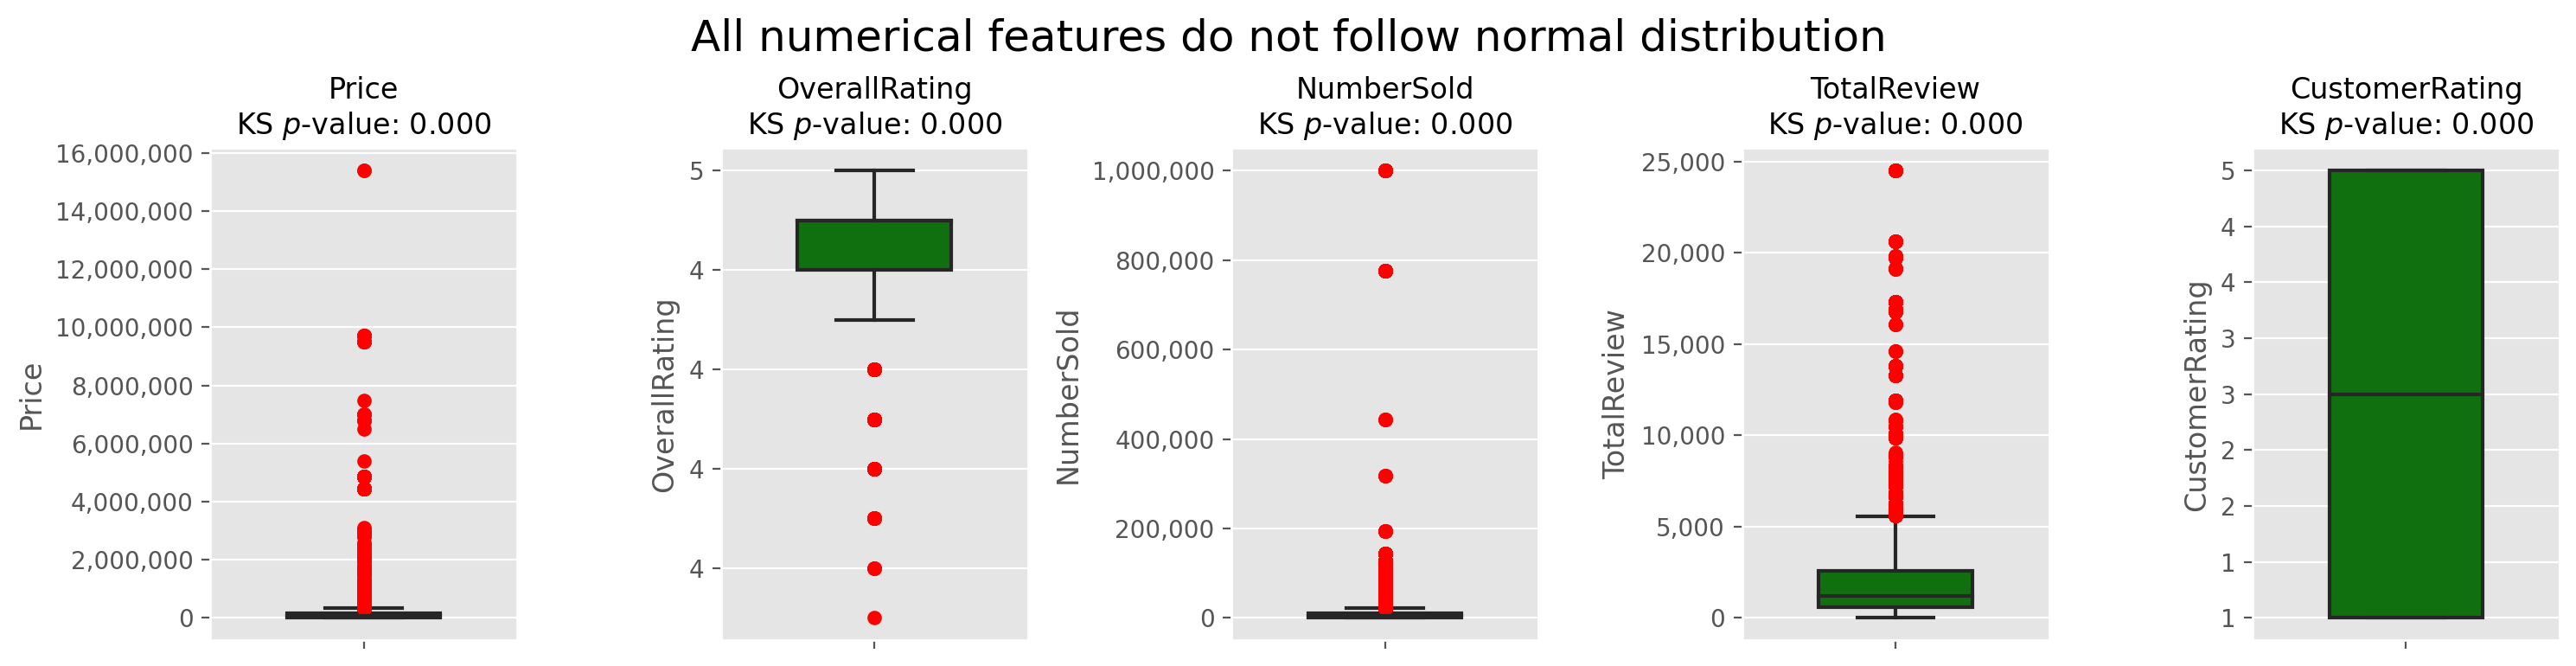

In [62]:
# select num features only
numerical_columns = df.select_dtypes(include='number')

plt.figure(figsize=(15, 4), dpi=200)

# create boxplot 
for i, col in enumerate(numerical_columns):
    plt.subplot(1, 5, i + 1)
    sns.boxplot(y=df[col], width=0.5, color='green', 
                flierprops=dict(marker='.', markerfacecolor='red', 
                                markeredgecolor='red', alpha=1, markersize=10))
    
    # perform the Kolmogorov-Smirnov test
    stat, p_value = kstest(df[col].dropna(), 'norm', args=(df[col].mean(), df[col].std()))
    plt.title(f'{col}\nKS $p$-value: {p_value:.3f}', size=12)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y_ticks))

plt.suptitle('All numerical features do not follow normal distribution', size=18, y=0.95)
plt.tight_layout()
plt.show()

**Comment**
- While the skewness and kurtosis already provided numerical sense of the distribution, they have not highlight elements of distribution such as quartiles and outliers (if any). To be able to explicitly show these, a bopxplot is needed.
- Above I made boxplots to show the distributions of numerical features in the dataset. Confirming the previous results, all features do not follow normal distributions. The test incorporates both visual and statistical approaches. In addition to boxplots, Kolmogorov-Smirnov test of distribution was used.
- From these boxplots, it appears that except customer ratings, all features have outliers but the number of outliers here are not critical since the predictive modeling will not use these numerical features. No inferential statistical tests will also be carried out with the features. They only serve as additional information about reviews which are the central point of discussion in this project.
- While boxplot highlights the quartiles and median, including outliers, boxplot does not display the exact shape of distribution. Multiple modes, for example, are hard to see in boxplots.

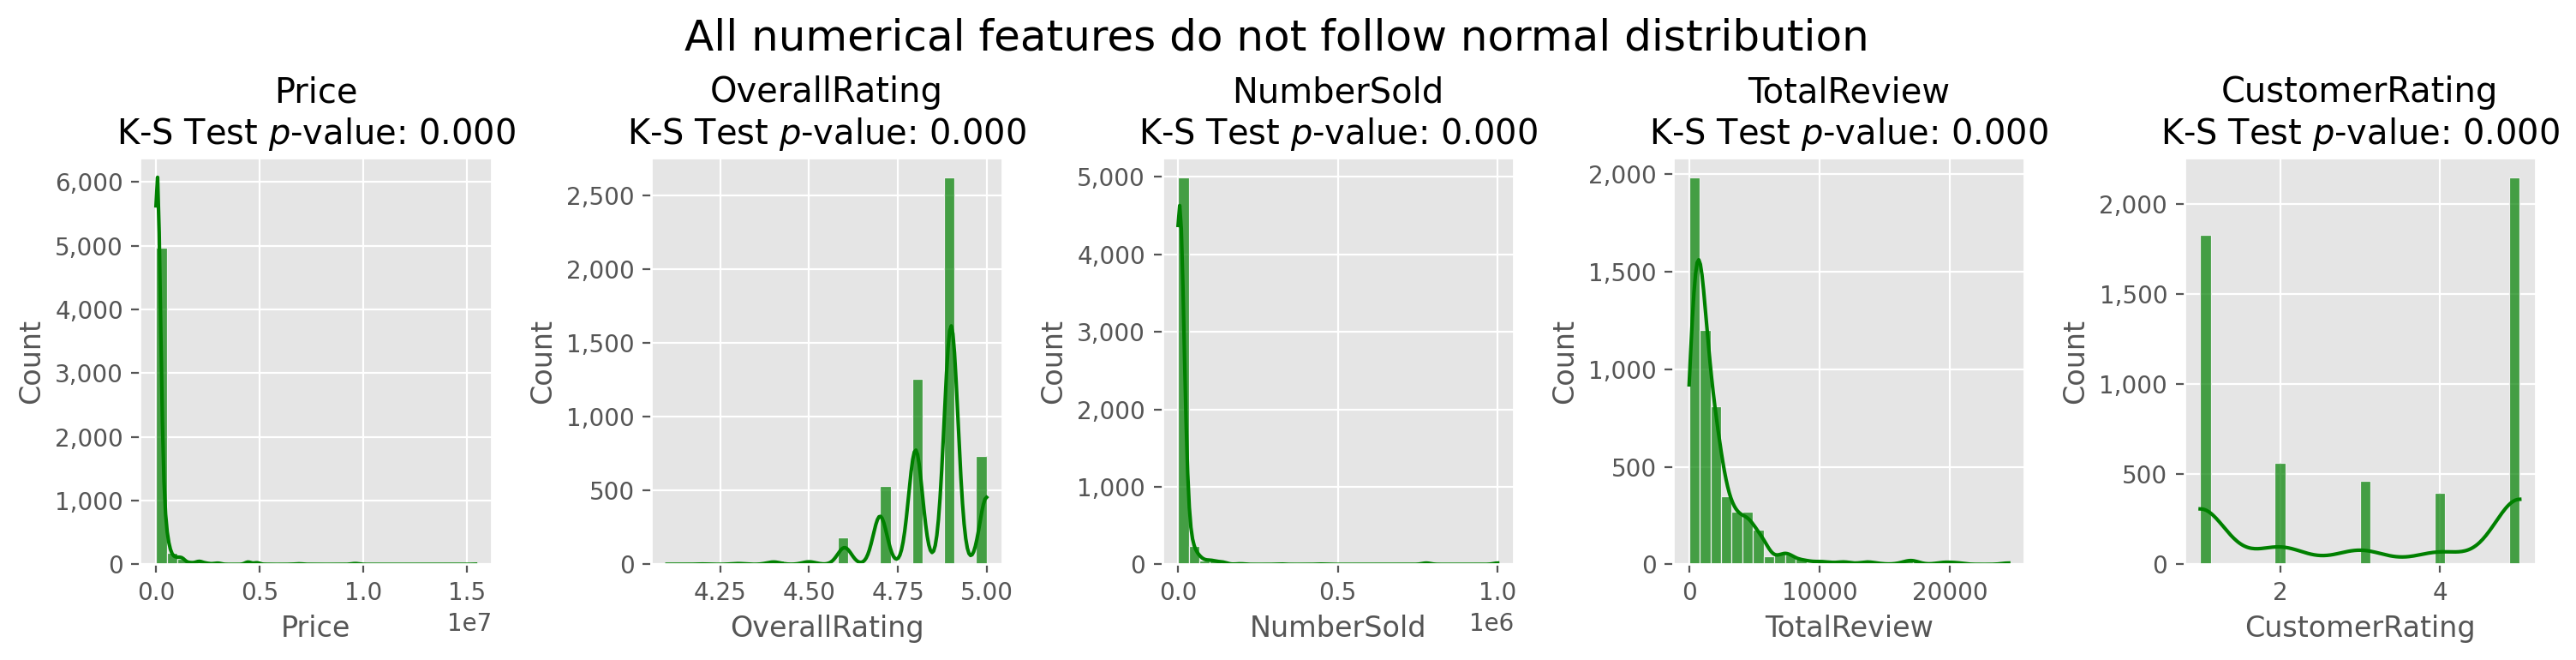

In [63]:
plt.figure(figsize=(15, 4), dpi=200)

# create histograms 
for i, col in enumerate(numerical_columns):
    plt.subplot(1, 5, i + 1)
    sns.histplot(df[col], bins=30, kde=True, color='green', alpha=0.7)
    stat, p_value = kstest(df[col].dropna(), 'norm', args=(df[col].mean(), df[col].std()))
    plt.title(f'{col}\nK-S Test $p$-value: {p_value:.3f}')
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
    
plt.suptitle('All numerical features do not follow normal distribution', size=18, y=0.95)
plt.tight_layout()
plt.show()

**Comment**: Histogram can sometimes displays the shape of distribution more clearly. For example, in the case of customer rating, the boxplot previously showed that the distribution is nearly symmetric as indicated by the similar distance between Q2 to Q1 and Q3. But once checked with histogram, the customer rating appears to be bimodal (having two distinct peaks) in the beginning and the end of the distribution. The concave-shaped distribution suggests that the majority of customers gave rating either 1 or 5, indicating strong polarity. This phenomenon is quite common in voluntary surveys with rating. Respondents or reviewers (in this case) will more likely to provide responses when they are either very dissatisfied or satisfied with the products or services. When they are neutral, they will be less likely to provide responses.

### **3.2 Distribution of Sentiments**
As previously pointed out, the main concerns of this project are customer reviews and sentiments. Other variables serve only as supporting points of the analysis, providing more depth on the two variables. Before moving on to the quantitative content analysis of customer reviews, we will begin the analysis by checking the distribution of sentiments, investigating similarity of proportion between negative or positive sentiments and potential dependencies of the sentiments with other variables such as emotion and customer satisfaction (CSAT) score.

#### **3.2.1 Is the proportion between negative and positive sentiment similar?**
Ideally, dataset for classification tasks should be balanced (no class significantly outnumers others). But in practice, imbalanced datasets based on the uneven distribution of class in the target variable are more common. The uneven distribution will pose a challenge for machine learning algorithms. ML algorithms will be biased to the majority class, leading to poor performance or underfitting in the minority class. Furthermore, some evaluation metrics, especially accuracy, can be misleading because accuracy requires balanced dataset. Other potential issue is overfitting to the majority class when the dataset is greatly imbalanced. For these reasons, checking if the distribution of negative and positive sentiment is generally similar or not is critical for the predictive modeling.

In [64]:
# get proportion of sentiments
sentiment_df = ((df['Sentiment'].value_counts(normalize=True)*100)
                .reset_index(name='proportion')
                .round(2)
                .rename(columns={'index':'Sentiment'}))

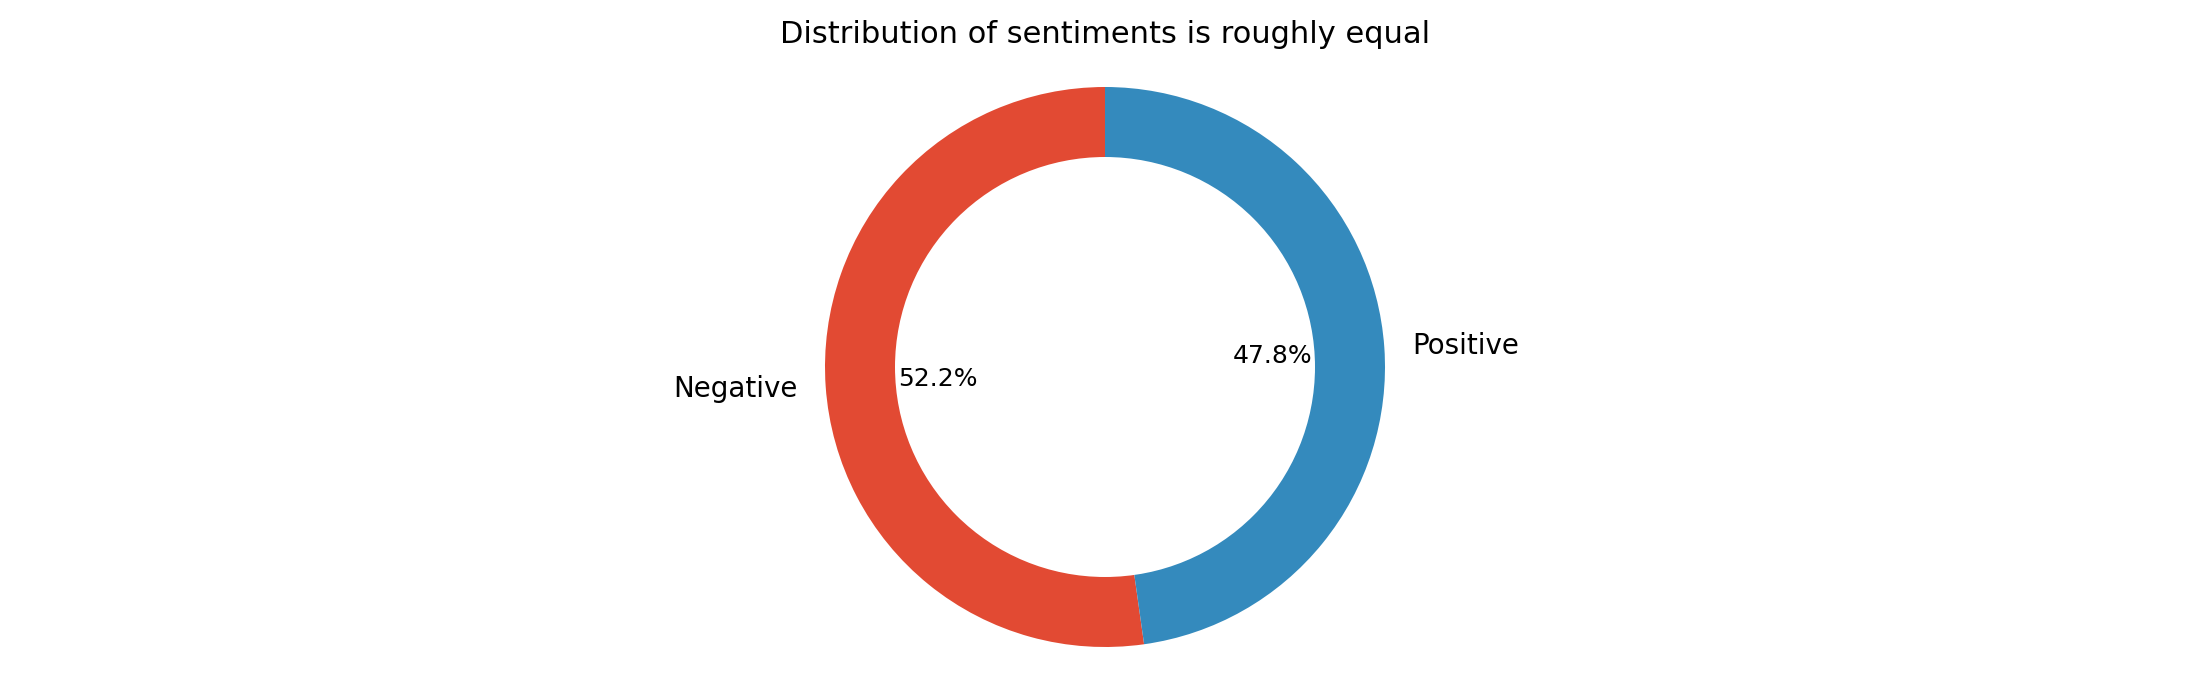

In [65]:
# make pie chart
fig, ax = plt.subplots(figsize=(14,4), dpi=200)
wedges, texts, autotexts = ax.pie(sentiment_df['proportion'],
                                  labels=sentiment_df['Sentiment'],
                                  autopct='%1.1f%%', startangle=90)

# set font size
for autotext in autotexts:
    autotext.set_fontsize(9)

# add circle to center
center_circle = plt.Circle((0,0), 0.75, fc='white')
fig.gca().add_artist(center_circle)
plt.axis('equal')
plt.title('Distribution of sentiments is roughly equal', size=11)
plt.show()

**Comment**
- Overall, the distribution of negative and positive sentiments is even, indicating that no resampling techniques, e.g., SMOTE, ADASYN, or NearMiss, to balance the distribution will be necessary. As shown on the donut chart, the negative sentiment consitutes 52.2% while the positive one is 47.8%. While the reviews have more negative sentiments, the difference between negative and positive sentiment rate is minor.
- So far, an insight about the overall distribution of the target variable has been obtained but it remains unclear whether these sentiments are related (dependent) to other factors such as emotions and satisfaction. Ideally, we will expect that positive sentiment will be associated with the positive emotions. We may also wonder whether the natural relationship between satisfaction level as measured with Likert 5-point scale and sentiment categories is also present. Obtaining these insights may not be directly relevant for this project but is fruitful for the next project, indicating that other than reviews, other factors play roles in predicting sentiments.

#### **3.2.2 Are there any associations between sentiments and emotions?**
Sentiment is a general term representing both attitudes and feelings about something. But emotion is more detailed than just negative, positive, or neutral. Even though they are generally difference, in essence they are related. For example, expression "Barangnya udah sampai. Suka banget!" (*I've received the product. Love it!*) indicates happiness of a user and at the same time represents their happiness. In practice, data annotation also benefits the information about sentiment when deciding to choose an emotion label. Due to its natural dependencies, their relationship may be reflected in data.

In [66]:
# build contingency table (cat x cat)
sentiment_emotion = pd.crosstab(df['Sentiment'], df['Emotion'])

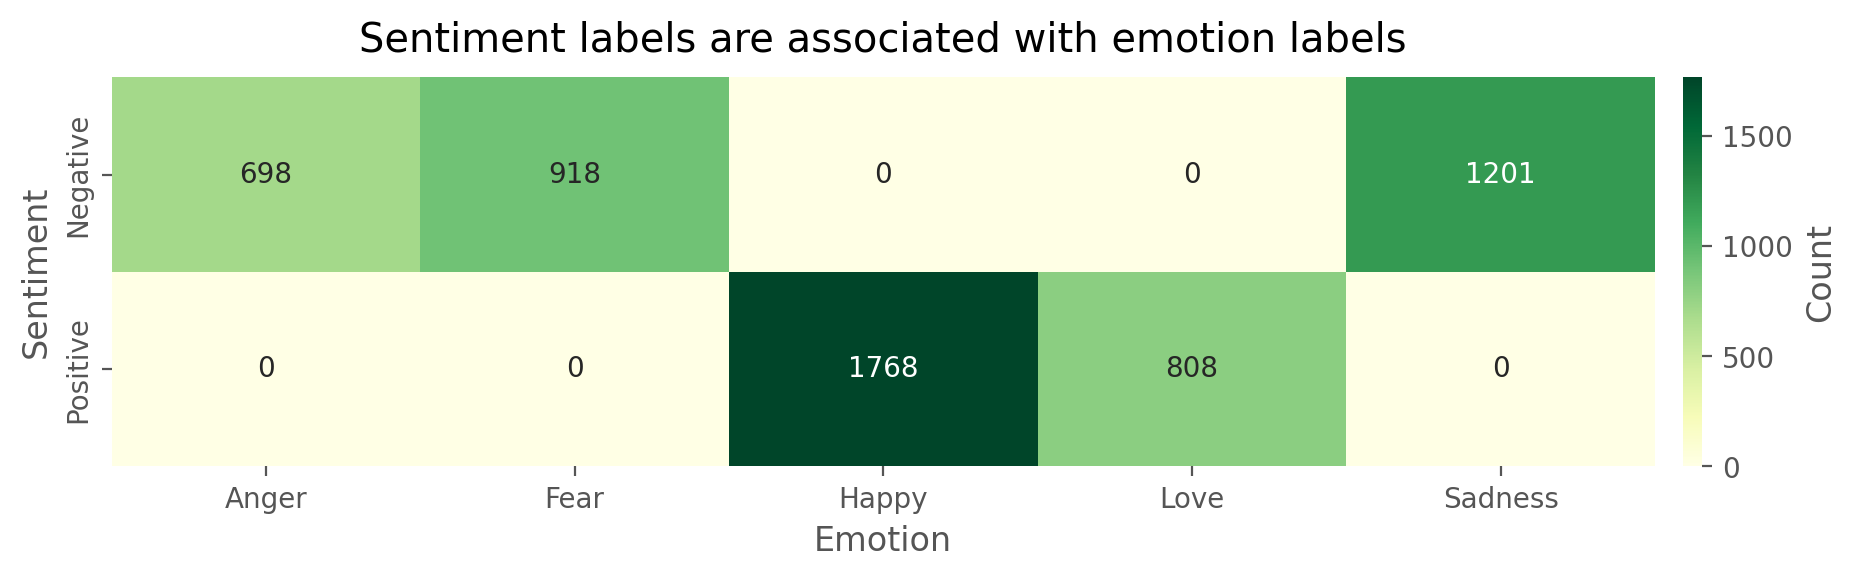

In [67]:
plt.figure(figsize=(10, 3), dpi=200)
sns.heatmap(sentiment_emotion, annot=True, cmap='YlGn', fmt='d',
            cbar_kws={'label': 'Count', 'pad': 0.015})

plt.title('Sentiment labels are associated with emotion labels', y=1.025)
plt.xlabel('Emotion')
plt.ylabel('Sentiment')
plt.yticks(va='center')

plt.tight_layout()
plt.show()

**Comment**
- At the surface level, the heatmap suggests that different emotions are mapped into the binary sentiments. As can be seen, negative emotions such as anger, fear, and sadness are only associated with negative sentiments, and the positive emotions such as happy and love are linked to positive sentiments.
- To test this assumption of dependence or association beetween emotion and sentiment, a chi-square test of independence can be used. Chi-square ($\chi^2$) of independence tests whether two categorical variables are significantly associated by comparing observed (O) and expected frequencies (E). While observed frequencies can be obtained from the contigency table, the expected frequency under assumption of independence (H0) is calculated by the following formula.

$$
\chi^2 = \sum\frac{(O-E)^2}{E}
$$


$$
\text{Expected }(E)=\frac{(\text{Row Total}\times \text{Column Total})}{\text{Grand Total}}
$$

In [68]:
# perform chi-square test
chi2, p, dof, expected = chi2_contingency(sentiment_emotion)

# display results
print(f'Chi-square stat: {chi2}, p-value: {p}, dof: {dof}')

# interpret p-value
alpha = 0.05  
print('Decision:')
if p < alpha:
    print("- Reject the null hypothesis: There is a significant association between Sentiment and Emotion.")
else:
    print("- Fail to reject the null hypothesis: There is no significant association between Sentiment and Emotion.")


Chi-square stat: 5393.0, p-value: 0.0, dof: 4
Decision:
- Reject the null hypothesis: There is a significant association between Sentiment and Emotion.


**Comment**: The output of the $\chi^2$ test affirms the insight drawn from the heatmap above, indicating that sentiment and emotion are significantly related: Some emotions only occur in specific emotions.

#### **3.2.3 To what extent do sentiments relate to CSAT score?**
While terminologically referring to different concepts, sentiments and satisfaction are closely related. Positive sentiments, for example, tend to corresponds with higher customer satisfaction score or CSAT (and vice versa). However, the relationship may not always be straightforward. In some cases, a customer might indicates a positive sentiment to a product but they remain providing low satisfaction score. 

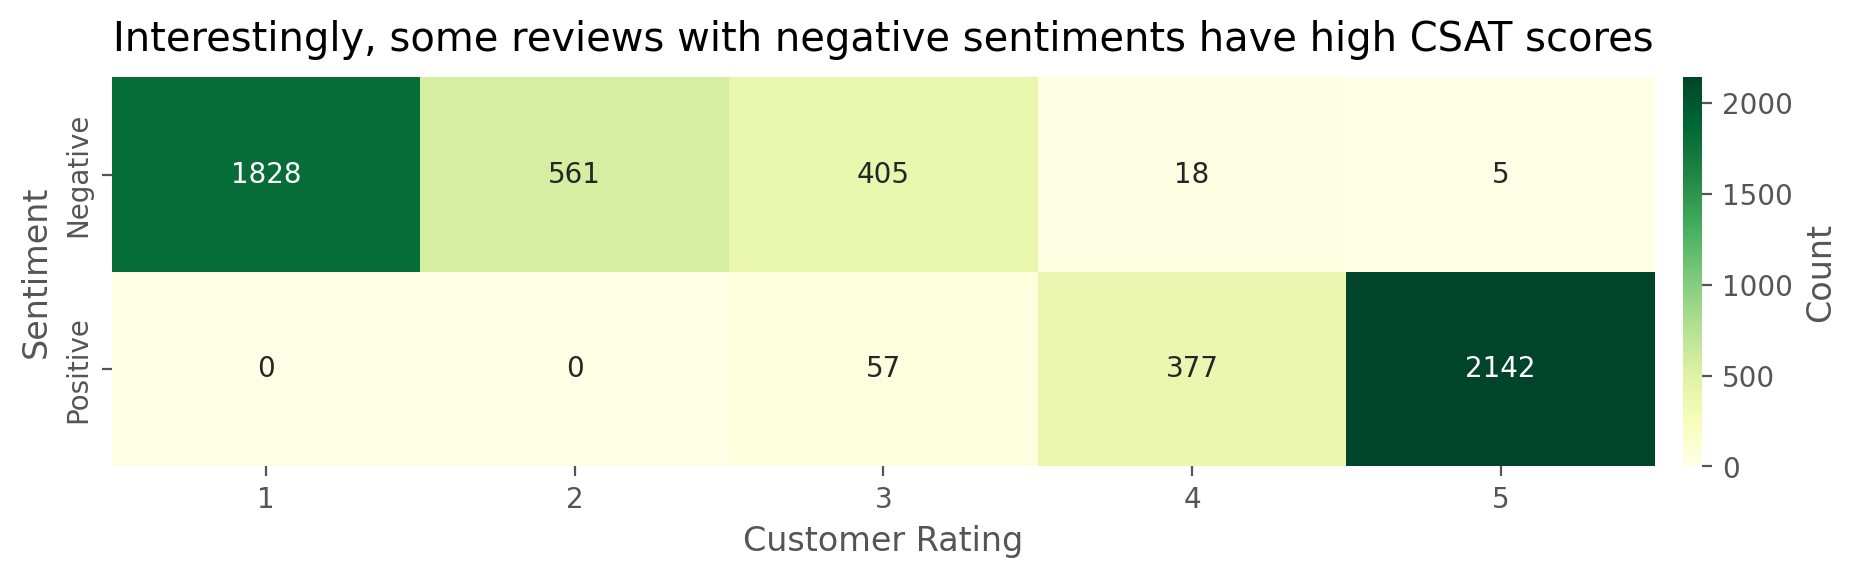

In [69]:
# generate crosstab for Sentiment and CustomerRating
sentiment_rating = pd.crosstab(df['Sentiment'], df['CustomerRating'])

# create the heatmap
plt.figure(figsize=(10, 3), dpi=200)
sns.heatmap(sentiment_rating, annot=True, cmap='YlGn', fmt='d',
            cbar_kws={'label': 'Count', 'pad': 0.015})

# add labels and title
plt.title('Interestingly, some reviews with negative sentiments have high CSAT scores', y=1.025)
plt.xlabel('Customer Rating')
plt.ylabel('Sentiment')
plt.yticks(va='center')

plt.tight_layout()
plt.show()

In [70]:
# perform chi-square test
chi2, p, dof, expected = chi2_contingency(sentiment_rating)

# display results
print(f'Chi-square stat: {chi2:.1f}, p-value: {p}, dof: {dof}')
# print(f'Expected frequencies:\n{expected}')

# interpret p-value
alpha = 0.05  
print('Decision:')
if p < alpha:
    print("- Reject the null hypothesis: There is a significant association between Sentiment and Customer Rating.")
else:
    print("- Fail to reject the null hypothesis: There is no significant association between Sentiment and Customer Rating.")

Chi-square stat: 5103.9, p-value: 0.0, dof: 4
Decision:
- Reject the null hypothesis: There is a significant association between Sentiment and Customer Rating.


**Comment**
- The heatmap above suggests that high ratings are related to positive sentiments. Conversely, there is an association between low rating and negative sentiments. However, as explained earlier about less straightforward relationship between satisfaction and sentiment, there are cases in which customers provided high ratings but the sentiment is negative. This issue will be further explored in the content analsysis later. 
- Furthermore, the chi-square ($\chi^2$) test output informs that sentiment and customer rating are considerably related, confirming the finding based on the contingency table (heatmap).

#### **3.2.4 Are expensive products associated with either negative sentiments?**
While seemingly unrelated, product price and sentiment can be related in some ways. For example, higher priced product often comes with higher expectations because customers already spent much money. When the product meets or even exeeds the expectations for jsutfying the price, the product can receive positive sentiment. Furthermore, since higher price is commonly associated with better quality, positive sentiment might highlight good quality of higher-priced products. Therefore, it is important to check if there is enough evidence to support this idea.

In [71]:
# function to format x-ticks with commas
def comma_format(x, pos):
    return f'Rp{int(x):,}'

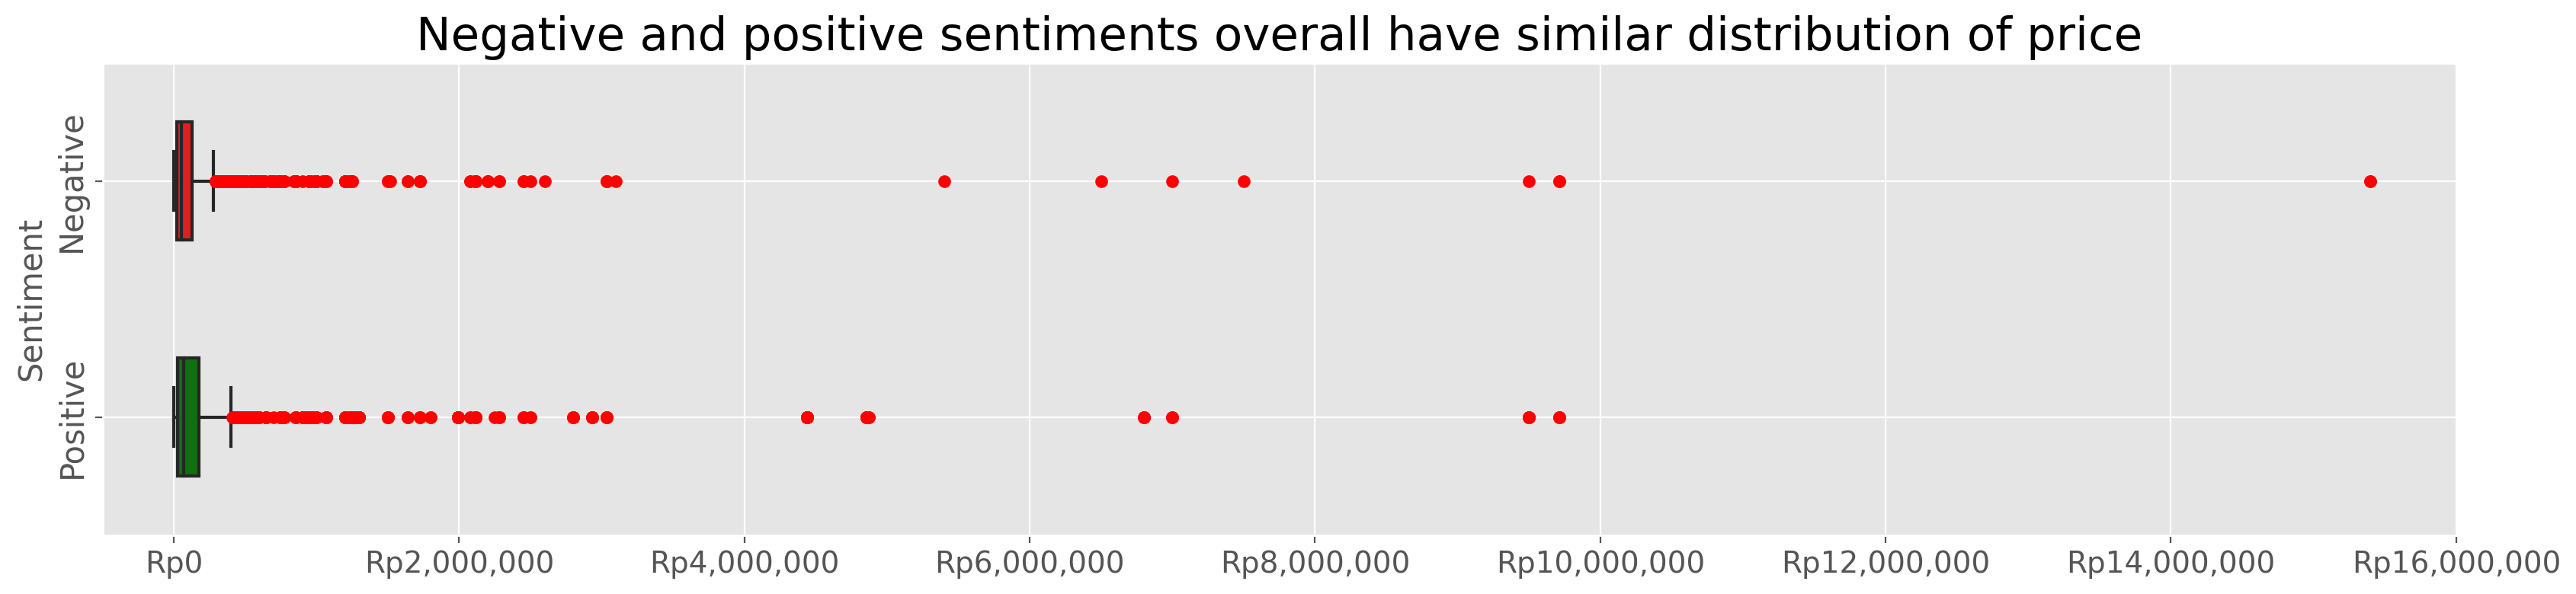

In [138]:
# calculate medians and sort labels
medians = df.groupby('Sentiment')['Price'].median().sort_values()
sorted_labels = medians.index

# create the plot
fig, ax = plt.subplots(figsize=(17, 4), dpi=200)
sns.boxplot(y='Sentiment', x='Price', data=df, order=sorted_labels, palette=['red', 'green'], ax=ax, width=0.5,
            flierprops=dict(marker='.', markerfacecolor='red', markeredgecolor='red', alpha=1, markersize=10))
ax.grid(True)
ax.set_yticklabels(ax.get_yticklabels(), rotation=90, va='center', size=15)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticks(), size=14)
ax.set_xlim(-500_000, 16_000_000)
ax.set_title('Negative and positive sentiments overall have similar distribution of price', size=22)
ax.set_xlabel(None, size=15)
ax.set_ylabel('Sentiment', size=15)

# plt.ticklabel_format(style='plain', axis='x')
plt.gca().xaxis.set_major_formatter(FuncFormatter(comma_format))
plt.tight_layout()
plt.show()

**Comment**
- At glance with limited evidence, it seems different sentiments are more similar than difference in terms of price range, meaning products with negative and positive sentiments have similar range of price. But it is noteworthy that there is possibly one extreme case in negative sentiment. This extreme case in negative sentiment might suggest that the high-valued product did not meet the customer expectation, leading the customer to leave a review with negative sentiment.
- To test this relationship, a similar test with the previous section (chi-square or $\chi^2$) to price and sentiment can be done. $\chi^2$ evaluates if there is any association between two categorical variable of interest. One challenge here is that the price is numerical. To convert to categorical, price must be binned into categories such as low, medium, and high.
- Nevertheless, one limitation of $\chi^2$ test is that it does not show the strength of the association. One interesting question here is why bother to know the magnitude of association. The reason is that statistical significance alone does not tell the strength and meaningfulness of the relationship. Understanding the magnitude of correlation enables us to evaluate whether the relationship between two variables of interest is negligible. In business context, the strength of association helps in decision making whether the relationship is strong enough to justify actions by stakeholders, e.g., targeting sentiment-related marketing efforts.
- The magnitude of relationship can be tested with $\phi_k$ (phi k). In essence, $\phi_k$ is similar to $\chi^2$ test in which it exploits a contingency table (cat x cat) for comparing observed and expected frequencies ([Baak et al, 2020](https://doi.org/10.1016/j.csda.2020.107043)).

In [73]:
# perform binning on price
df['PriceBinned'] = pd.qcut(df['Price'], q=3, labels=['Low', 'Medium', 'High'])

# cross-tab sentiment and price
sentiment_price = pd.crosstab(df['Sentiment'], df['PriceBinned'])

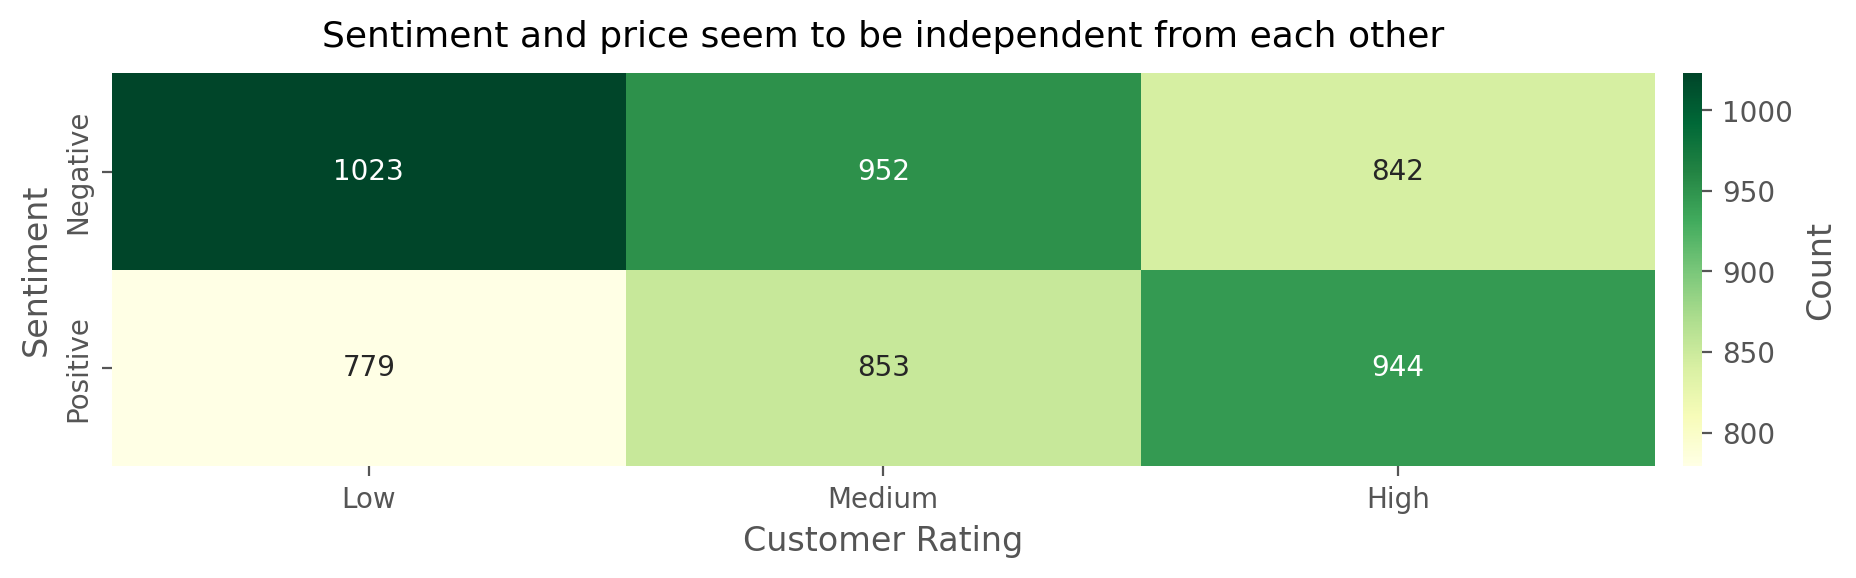

In [74]:
# create the heatmap
plt.figure(figsize=(10, 3), dpi=200)
sns.heatmap(sentiment_price, annot=True, cmap='YlGn', fmt='d',
            cbar_kws={'label': 'Count', 'pad': 0.015})

# add labels and title
plt.title('Sentiment and price seem to be independent from each other', 
          y=1.025, size=13)
plt.xlabel('Customer Rating')
plt.ylabel('Sentiment')
plt.yticks(va='center')

plt.tight_layout()
plt.show()

In [75]:
# perform chi-square test
chi2, p, dof, expected = chi2_contingency(sentiment_price)

# display results
print(f'Chi-square stat: {chi2:.1f}, p-value: {p:.4f}, dof: {dof}')
# print(f'Expected Frequencies:\n{expected}')

# interpret p-value
alpha = 0.05  
print('Decision:')
if p < alpha:
    print("- Reject the null hypothesis: There is a significant association between Sentiment and Price.")
else:
    print("- Fail to reject the null hypothesis: There is no significant association between Sentiment and Price.")

Chi-square stat: 33.6, p-value: 0.0000, dof: 2
Decision:
- Reject the null hypothesis: There is a significant association between Sentiment and Price.


**Comment**: The association between sentiment and product price is statistically significant, indicating price and sentiment are not independent of each other. On the other hand, the $\phi_k$ correlation test shows that the strength of this association is weak with a coefficient of 0.1. While the $\chi^2$ test shows significant association, the $\phi_k$ suggests that price only slightly affects sentiment. In brief, in spite of statistically significant relationship, the practical importance is not strong.

In [76]:
# check correlation
(df.loc[:, ['Sentiment', 'Price']].phik_matrix(interval_cols=['Price'])
 .style.background_gradient(cmap='YlGn')
 .format('{:.2f}'))

#### **3.2.4 Beside price, to what extent do other variables correlate with sentiment?**
Previously, it was demonstrated that sentiment and price have weak correlation but whether other features also have weak correlations remains an open question to answer. Here, we will test whether there are variables with moderate to high correlations with sentiments. Testing correlations between sentiment and other variables can indicate the potential factor influencing sentiment apart from customer reviews. For business, strong correlations provide a guide which variable should receive more attention since they have strong tie to sentiment outcomes.

In [77]:
# subset dataset and compute phi k correlation
filtered_df = df[['Sentiment', 'Emotion'] +  df_numeric.columns.values.tolist()]
phik_matrix = filtered_df.phik_matrix(interval_cols=df_numeric.columns.tolist())

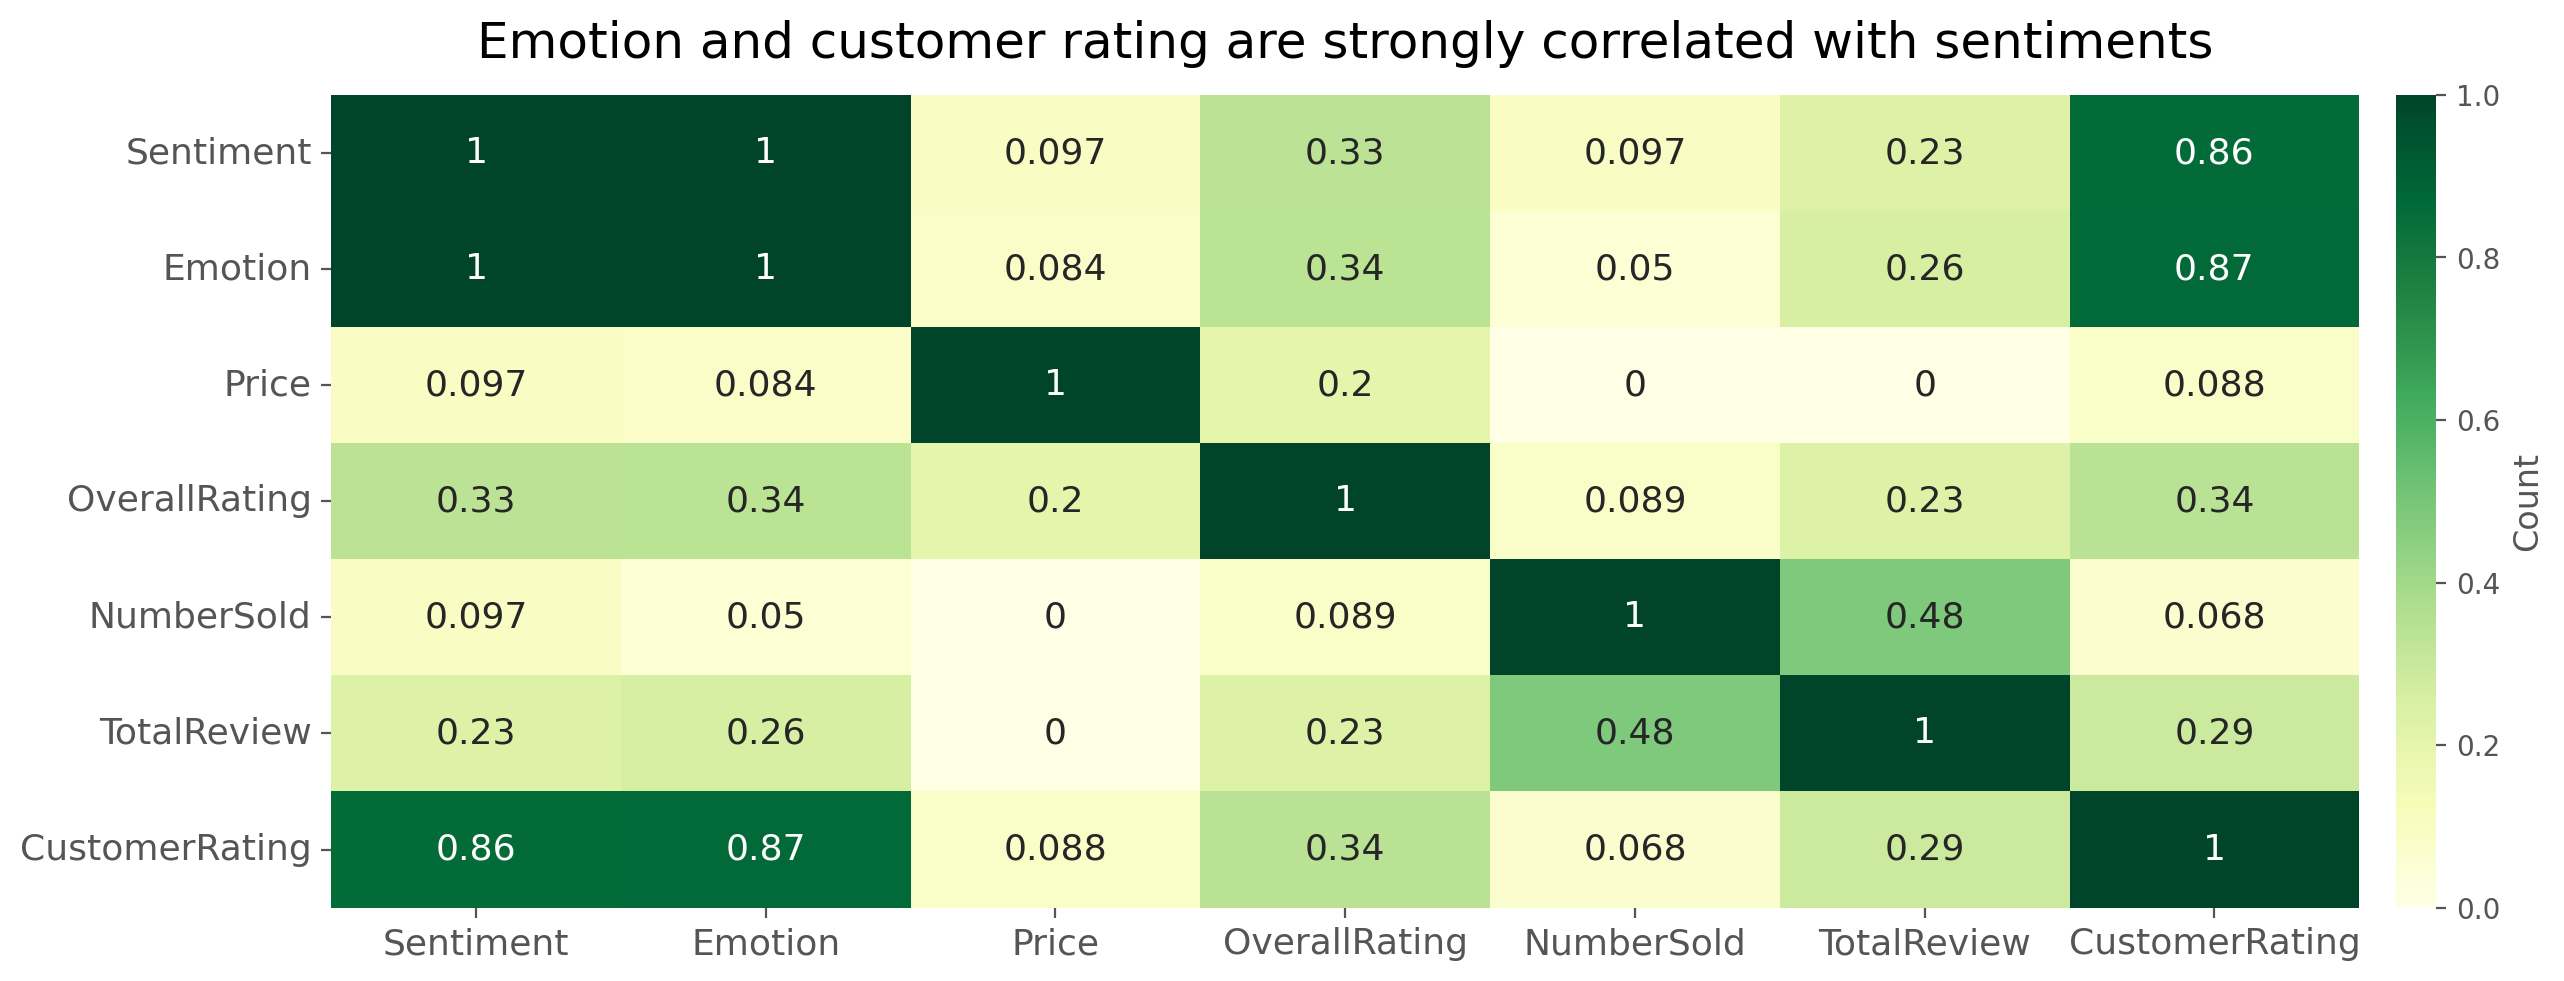

In [78]:
# create the heatmap
plt.figure(figsize=(14, 5), dpi=200)
sns.heatmap(phik_matrix, annot=True, cmap='YlGn',
            cbar_kws={'label': 'Count', 'pad': 0.015},
            annot_kws={"size": 13})

# add labels and title
plt.title('Emotion and customer rating are strongly correlated with sentiments', 
          y=1.025, size=18)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks(va='center', size=13)
plt.xticks(size=13)

plt.tight_layout()
plt.show()

**Comment**
- Since the focus here is the correlations between the sentiments and other variables, let us ignore the correlations between variables other than sentiment, e.g., number sold vs total review. As illustrated from the heatmap of $\phi_k$ correlation coefficients, it is sentiment and customer rating pairs that have strong correlations. The strong correlation means that when the customer rating or CSAT rating score increases the sentiment value will also increase. By increasing sentiment value, it means the sentiment will be positive as the rating score increases.This is not surprising as we will expect such result.
- Similar to the correlation between sentiment and customer rating, sentiment and emotion have very high correlation coefficient, indicating a strong relationship between the two variables.
- The output of the correlation test can be triangulated with the previous $\chi^2$ test result in Section 2.3.2 and 2.3.3. Just for a reminder, the $\chi^2$ tests suggested significant associations of sentiment to emotion and customer satisfaction score.

### **3.3 Content Analysis of Customer Reviews**
The goal of this project is to develop a predictive model for user sentiments on product reviews. Consequently, customer reviews and sentiments become the key variables in this project. Previously, we have explored variable sentiment and demonstrated how this variable is related to other variables such as customer rating and emotion with $\chi^2$ test of independence and $\phi_k$ correlation test.

In this section, we attempt to carry out text analysis, involving mainly customer reviews to explore the most frequent words and word combinations (*n*-gram). In addition to informing potential treatment in the feature engineering phase later, this content analysis is expected to provide an understanding of the review content cleanliness and patterns of the content across different variables, particularly sentiment as the target variable to predict, emotion, and satisfaction rating score.  

#### **3.3.1 What are the most frequent words?**
The content analysis starts from examining the most frequent words to provide insights into the aboutness of the reviews. While performing keyword analysis can be beneficial to characterize the domain specific terms, we are unable to do this due to inavailability of a reference corpus, e.g., COCA, COHA, or BNC, in Indonesian.

In [79]:
# prepare stop words
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('indonesian'))
stop_words -= {'tidak'}
custom_stopwords = {'yang', 'aja', 'nya', 'sih', 'kok', 'oh', 'deh', 'ya',
                    'kan', 'nih'}
stop_words.update(custom_stopwords)

# define synonyms
synonym_dict = {
    'oke': 'ok', 'ga': 'tidak', 'tdk': 'tidak', 'g':'tidak', 'gak':'tidak',
    'kalo': 'kalau', 'jg': 'juga', 'dgn':'dengan', 'bgt':'banget', 'sy':'saya',
    'sdh':'sudah', 'yg':'yang', 'gk':'tidak', 'tp':'tapi', 'udh':'sudah',
    'jd':'jadi', 'd':'di', 'krn':'karena', 'utk':'untuk', 'bs': 'bisa'
}

**Comment**
- Before extracting most frequent words, the stop words and synonyms were set. Stop words are a collection of words with less to no semantic content. Words such as prepositions, articles, and discourse particles, do not contribute significantly to the overall meaning of the text. They only serves to indicate grammatical relations or convey nuances (e.g., *deh*, *sih*, *kok*) in conversation.
- It is important to note that negation marker *tidak* is excluded from the stop word list since *tidak* is a crucial word in understanding opinions via the word frequency.
- The synonym dictionary contains common abbreviations or contractions in Indonesian. In computer mediated communication, especially written, Indonesians normally use contractions when communicating informally to others. To acommodate this common practice, the synonyms were prepared.
- More importantly, since word frequency is basically bag-of-words, if synonyms are not defined, two words with the same meanings will be treated as separate words, e.g., *bs* vs *bisa*.

In [80]:
# function to normalize elongated words (e.g., sukaaaa -> suka)
def normalize_repeated_chars(word):
    return re.sub(r'(.)\1{2,}', r'\1', word)                            # replace >=3 chars with 1 char

# preprocess function
def tokenize_text(text):
    if isinstance(text, str):                                           # check if the input is a string
        text = text.lower()                                             # convert to lowercase
        text = re.sub(r'\d+', '', text)                                 # remove numbers
        text = re.sub(r'\W+', ' ', text)                                # remove punctuation
        text = re.sub(r'http\S+|www\S+', '', text)                      # remove URLs
        tokens = text.split()                                           # split into tokens
        tokens = [normalize_repeated_chars(word) for word in tokens]    # normalize elongated words
        tokens = [synonym_dict.get(word, word) for word in tokens]      # replace with synonym if it exists
        tokens = [word for word in tokens if word not in stop_words]    # remove stopwords
        return tokens
    return []                                                           # if not string, return an empty list

# apply preprocessing
df['tokens'] = df['CustomerReview'].apply(tokenize_text)

**Comment**
- For building word frequencies, word tokenization should be carried out. By definition, word tokenization is splitting text into smaller units (word). But prior to tokenization, text cleaning is necessary to regularize tokens and remove unnecessary elements, e.g., URLs, punctuation marks, and numbers.
- Numbers and URLs must be removed before splitting the text into words since they usually appear uniquely. For example, number 5 only occurs once. If there are many words occurring in small number of frequency, they can become noise.
- With regards to regularization, not only lowercasing was done but also normalizing elongated words was performed. Indonesians typically elongate some expressions (e.g., *sukaaa* -> *suka* (like)) to intensify their emotions. While this simple regularization, especially for elongated words, cannot apply to all cases (e.g., *sukaa*, 2 repeated characters), this technique remains our top consideration. We prevent unintentionally normalizing two repeated characters in English or Arabic in which code-mixing occurs (e.g., *Good. Bagus bangeeet productny* (Good. Very good product)).

In [81]:
# check output
df.loc[:5, ['CustomerReview', 'tokens', 'Sentiment']]

CustomerReview  \
0  Alhamdulillah berfungsi dengan baik. Packaging...   
1  barang bagus dan respon cepat, harga bersaing ...   
2  barang bagus, berfungsi dengan baik, seler ram...   
3  bagus sesuai harapan penjual nya juga ramah. t...   
4  Barang Bagus, pengemasan Aman, dapat Berfungsi...   
5                       barang bagus, seller ramah..   

                                              tokens Sentiment  
0  [alhamdulillah, berfungsi, packaging, aman, re...  Positive  
1    [barang, bagus, respon, cepat, harga, bersaing]  Positive  
2  [barang, bagus, berfungsi, seler, ramah, pengi...  Positive  
3  [bagus, sesuai, harapan, penjual, ramah, trima...  Positive  
4       [barang, bagus, pengemasan, aman, berfungsi]  Positive  
5                     [barang, bagus, seller, ramah]  Positive

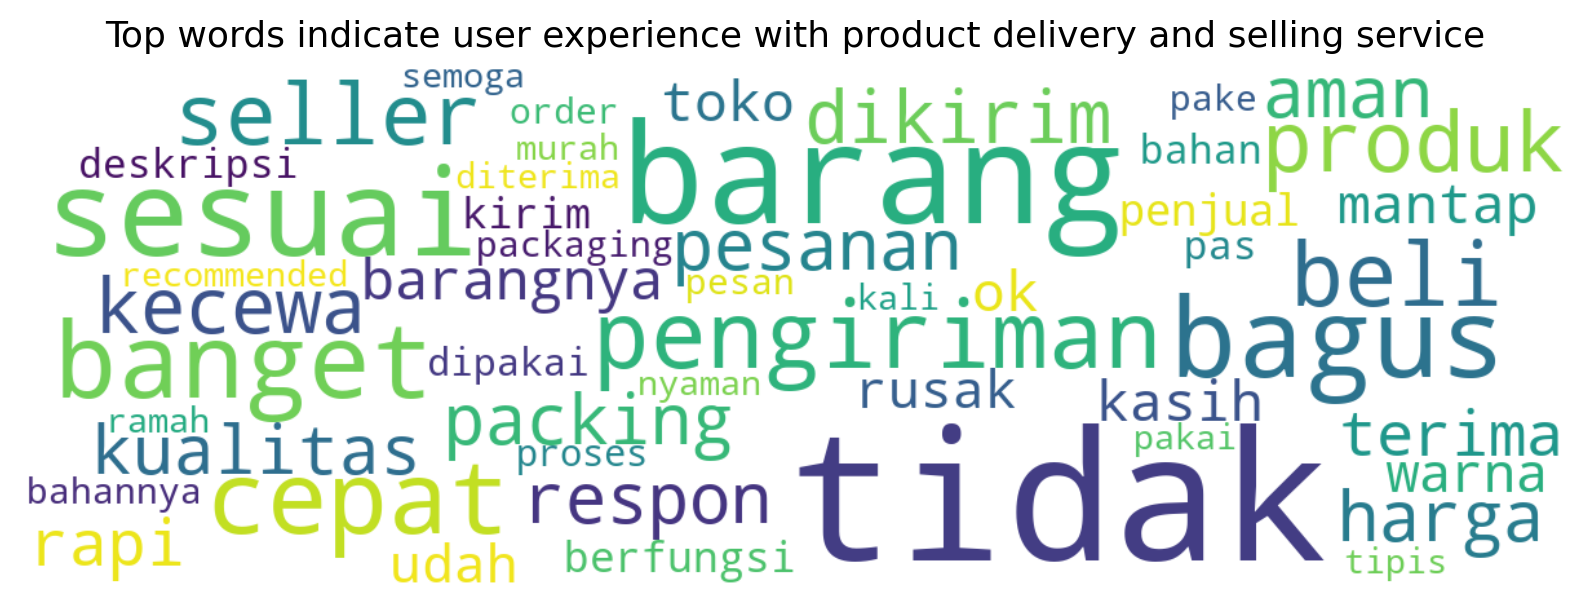

In [82]:
# prepare word counts
all_tokens = [word for tokens in df['tokens']
              for word in tokens if word not in stop_words]
word_counts = Counter(all_tokens)

# create word cloud
wordcloud = (WordCloud(width=1200, height=400, background_color='white',
                       max_words=50, prefer_horizontal=1.0)
             .generate_from_frequencies(dict(word_counts.most_common(50))))

plt.figure(figsize=(10, 5), dpi=200)
plt.imshow(wordcloud, interpolation='bilinear', cmap='tab20')
plt.title('Top words indicate user experience with product delivery and selling service', size=13, y=1.01)
plt.axis('off')
plt.show()

**Comment**
- The word cloud here summarizes the most frequent words in the customer reviews on products they bought on Tokopedia. In general, it appears that the most frequent words indicate mixed sentiments about products delivered (e.g., *barang*, *pesanan*, *cepat*) and selling service (e.g., *seller*, *toko*, *ramah*). The mixed sentiments can be indicated by the frequeent use of words *rusak* and *kecewa* for the negative sentiment and *rapi*, *mantap*, *aman* for positive.
- The word cloud also suggests that negation marker *tidak* is commonplace in the customer reviews but it remains unclear here whether the negation marker is used to indicate negative or positive sentiment since in different context, word *tidak* can indicate different sentiments. For example, *barang tidak sesuai deskripsi* has negative sentiment but *barang sudah diterima. Tidak ada kerusakan* has positive sentiment. In these two cases, word *tidak* modifies or negates different word. Even though the word serves only as a modifier, the negation plays a critical role. What words it negates determines the sentiment of the expression.
- Before revealing in what context the negation marker appears, we will show the frequency value of *tidak* and other top words in the word cloud.

In [83]:
# Prepare word counts
all_tokens = [word for tokens in df['tokens'] for word in tokens]
word_counts = Counter(all_tokens)

# Create DataFrame for the most common words
most_common_words = word_counts.most_common(10)  
word_freq_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

In [84]:
# prepare word counts
all_tokens = [word for tokens in df['tokens'] for word in tokens]
word_counts = Counter(all_tokens)

# create df for most common words
most_common_words = word_counts.most_common(10)  
word_freq_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

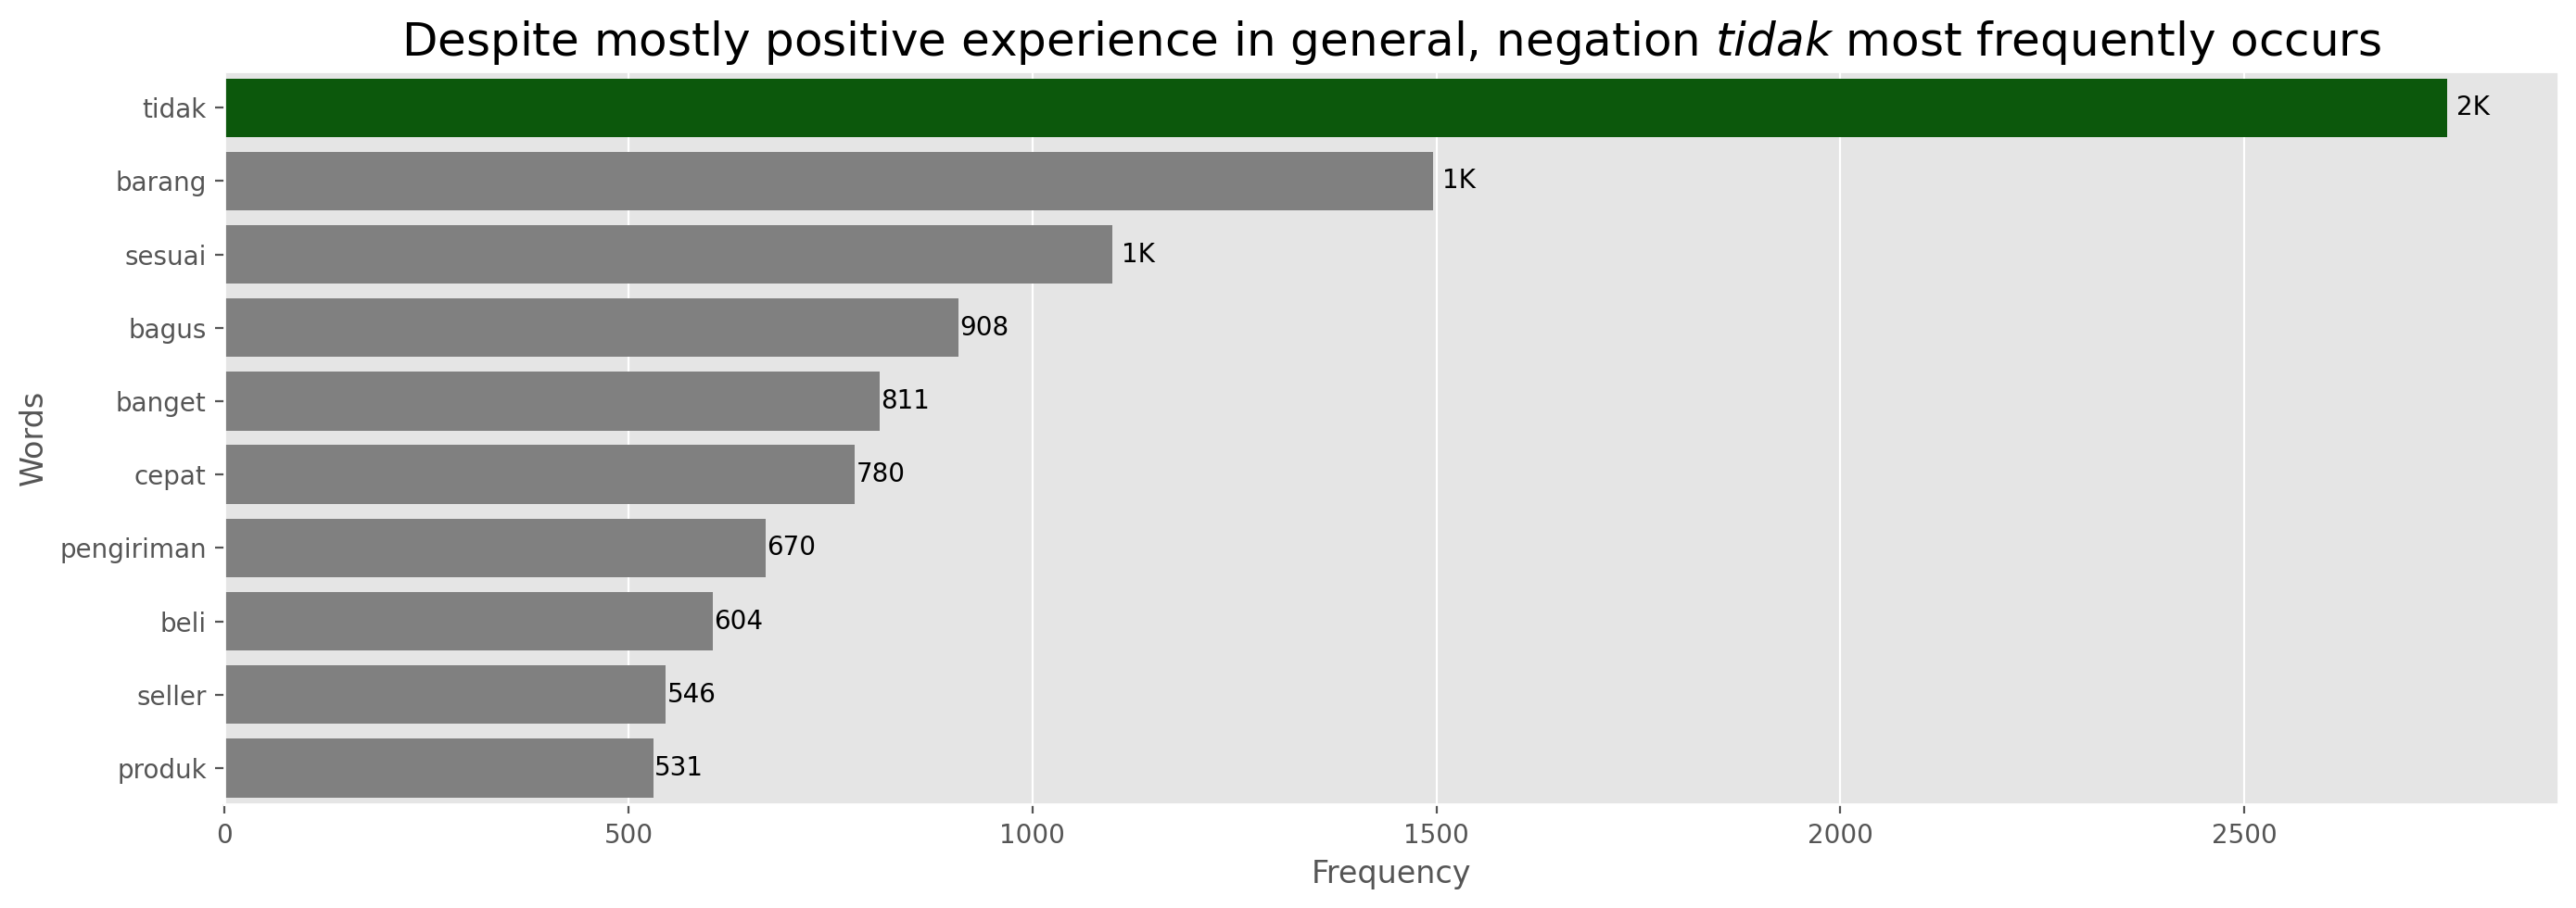

In [85]:
plt.figure(figsize=(14, 5), dpi=200)

# create color list for words
colors = ['darkgreen' if w == 'tidak' else 'grey' for w in word_freq_df['Word']]

# create bar plot with the color list
ax = sns.barplot(x='Frequency', y='Word', data=word_freq_df, palette=colors)

# adding labels to bars
for p in ax.patches:
    count_value = int(p.get_width())
    label = f'{count_value // 1000}K' if count_value >= 1000 else str(count_value)
    ax.annotate(label,
                (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='center', va='center', xytext=(10, 0),
                textcoords='offset points', fontsize=10)
plt.title('Despite mostly positive experience in general, negation $tidak$ most frequently occurs',
          size=18)
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.tight_layout()
plt.show()

**Comment**
- The bar chart displays the top-10 most frequent words in the customer reviews. As indicated by the word cloud earlier, word *tidak* frequently appears but the frequency was unknown. The bar chart fills the gap in the understanding of the frequency. The negation mark occurs approx 2,000 times in the reviews, and its frequency of occurrences is twice more higher than the second most common word *barang*.
- While the frequent occurrences of *tidak* is normal as it is the part of stop words, we contend that this word is central in identifying sentiments. This is the reason why we retain the word.
- The second word *barang* is also critical in the reviews despite not indicating the sentiments of the reviews, *barang* is one of the central discussion to refer to product the customers bought from Tokopedia.

#### **3.3.2 Is word *tidak* used in negative or positive context?**
Previously, it was found that *tidak* is among the popular word in the customer reviews but the problem is whether this negation marker occurs in what context. To answer such question, a function to clean the reviews should be defined. Below, I build a text cleaning function whose general steps are similar to the word tokenization function. The main diffence is that the expected output of this function is not words appearing in isolation but in context. Displaying words in context allows us to concretely learn how the negation marker occurs. More specifically, to be able to display the word in its immediate context, a concorancer will be used. In corpus linguistics, concordance is a technique to display words in its immediate context.

In [86]:
# preprocess function 
def clean_text(text):
    if isinstance(text, str):                                           # check if the input is a string
        text = text.lower()                                             # convert to lowercase
        text = re.sub(r'\d+', '', text)                                 # remove numbers
        text = re.sub(r'\W+', ' ', text)                                # remove punctuation
        text = re.sub(r'http\S+|www\S+', '', text)                      # remove URLs
        words = text.split()                                            # split into words
        words = [normalize_repeated_chars(word) for word in words]      # normalize elongated words
        words = [synonym_dict.get(word, word) for word in words]        # replace with synonym if it exists
        return ' '.join(words)                                          # rejoin words into a cleaned string
    return text                                                         # if not string, return as is

# apply the cleaning
df['CleanReview'] = df['CustomerReview'].apply(clean_text)

# check output
df.loc[:5, ['CustomerReview', 'CleanReview', 'CustomerRating']]

CustomerReview  \
0  Alhamdulillah berfungsi dengan baik. Packaging...   
1  barang bagus dan respon cepat, harga bersaing ...   
2  barang bagus, berfungsi dengan baik, seler ram...   
3  bagus sesuai harapan penjual nya juga ramah. t...   
4  Barang Bagus, pengemasan Aman, dapat Berfungsi...   
5                       barang bagus, seller ramah..   

                                         CleanReview  CustomerRating  
0  alhamdulillah berfungsi dengan baik packaging ...               5  
1  barang bagus dan respon cepat harga bersaing d...               5  
2  barang bagus berfungsi dengan baik seler ramah...               5  
3  bagus sesuai harapan penjual nya juga ramah tr...               5  
4  barang bagus pengemasan aman dapat berfungsi d...               5  
5                          barang bagus seller ramah               5

In [87]:
# join reviews with score 1 into one text
corpus = ' '.join(df['CleanReview'].tolist())

# build concordance index
conc_index = ConcordanceIndex(nltk.word_tokenize(corpus))

# display the KWIC
conc_index.print_concordance('tidak', width=100, lines=10)

Displaying 10 of 2751 matches:
epat sampai kualitas bagus dan pengiriman aman tidak ada yang pecah manstapu bagus berkualitas sesu
bar dan memberikan berbagai saran yang pembeli tidak tahu mantap lah barang sampai dengan cepat pac
i dengan cepat packingnya rapi dan amat sekali tidak ada bagian acrylic yang pecah berfungsi dengan
k jelek yang pasti jauh dari ori mousepad jadi tidak bisa dipakai kl di charger jadi getar parah ba
 dipakai kl di charger jadi getar parah barang tidak sesui foto kayak barang lapak sebelah yang har
i lg walaupun sedikit mahal ternyata barangnya tidak sama dengan order sebelumnya tidak bisa di pak
a barangnya tidak sama dengan order sebelumnya tidak bisa di pakai kecewa parah nggk berkah jualan 
a parah nggk berkah jualan gitu kecewa penjual tidak tanggung jawab komplen berhari gada solusi pas
 ya yang ngejual kecewa gamau lagi beli disini tidak tanggung jawab barang sampai terlalu lama pada
anja di tempat kamu lain di pesan lain dikirim tidak ada tissue pembe

**Comment**: In the concordance lines, the negation marker *tidak* serves to indicate different intent. The first line suggests that the word is used to inform the seller that the product the customer bought was not broken when received but the fourth line indicates a broken or faulty product. While already got the context, the patterns of usage of *tidak* remain unknown. To find patterns in the use of *tidak* or at least to specify where to focus the concordance, *n*-grams can be utilized. *N*-gram is contigious sequence of words or characters in *n* items. Here, we will specify `n=2` and `n=3` for bigrams and trigrams, respectively.

In [88]:
# init CountVectorizer for bigrams and trigrams
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), token_pattern=r'\b\w+\b')
trigram_vectorizer = CountVectorizer(ngram_range=(3, 3), token_pattern=r'\b\w+\b')

# fit and transform the reviews
bigram_X = bigram_vectorizer.fit_transform(df['CleanReview'])
trigram_X = trigram_vectorizer.fit_transform(df['CleanReview'])

# get n-gram counts
bigram_counts = bigram_X.toarray().sum(axis=0)
trigram_counts = trigram_X.toarray().sum(axis=0)
bigram_names = bigram_vectorizer.get_feature_names_out()
trigram_names = trigram_vectorizer.get_feature_names_out()

# create df for n-grams and their counts
bigram_df = pd.DataFrame({'ngram': bigram_names, 'count': bigram_counts})
trigram_df = pd.DataFrame({'ngram': trigram_names, 'count': trigram_counts})

# filter for bigrams and trigrams starting with "tidak"
bigram_df = bigram_df[bigram_df['ngram'].str.startswith('tidak')].sort_values(by='count', ascending=False)
trigram_df = trigram_df[trigram_df['ngram'].str.startswith('tidak')].sort_values(by='count', ascending=False)

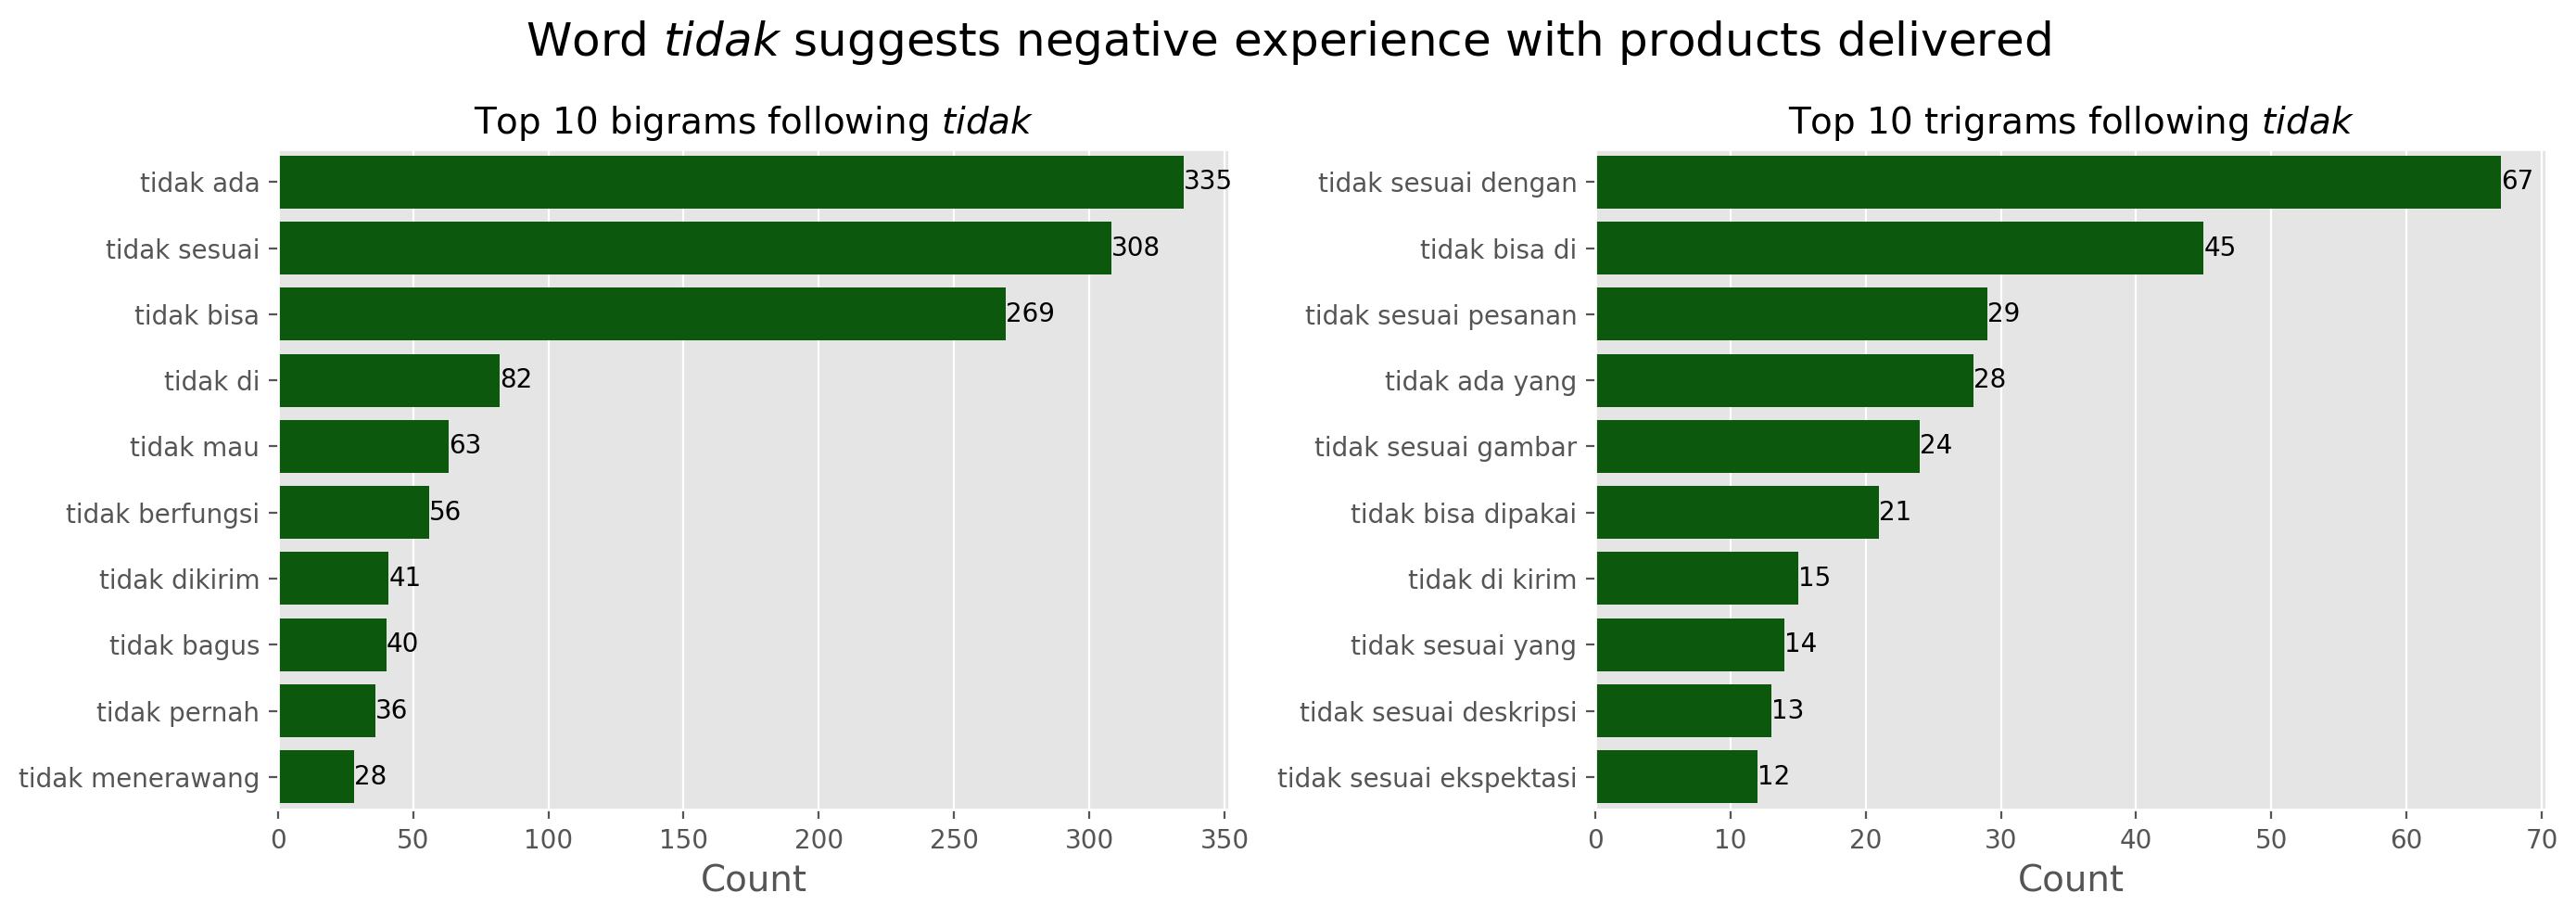

In [89]:
# create figure with two subplots 
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=200)

# plot for bigrams
sns.barplot(x='count', y='ngram', data=bigram_df.head(10), ax=axes[0], color='darkgreen')
for index, value in enumerate(bigram_df.head(10)['count']):
    axes[0].text(value, index, str(value), va='center')
axes[0].set_title('Top 10 bigrams following $tidak$', fontsize=14)
axes[0].set_xlabel('Count', fontsize=14)
axes[0].set_ylabel(None, fontsize=14)

# plot for trigrams
sns.barplot(x='count', y='ngram', data=trigram_df.head(10), ax=axes[1], color='darkgreen')
for index, value in enumerate(trigram_df.head(10)['count']):
    axes[1].text(value, index, str(value), va='center')
axes[1].set_title('Top 10 trigrams following $tidak$', fontsize=14)
axes[1].set_xlabel('Count', fontsize=14)
axes[1].set_ylabel(None, fontsize=14)

plt.suptitle('Word $tidak$ suggests negative experience with products delivered', size=18)
plt.tight_layout()
plt.show()

**Comment**: Overall, the *n*-grams containing *tidak* suggest customers have unpleasant experience with the products such as unsuitable products, not functioning products, or not meeting customers' expectations. Apparently, the overall patterns here indicate more negative sentiments (e.g., *tidak sesuai*, *tidak bisa*, *tidak berfungsi*, *tidak dikirim*, *tidak bagus*), rather than positive ones. To make sure, we can utilize bigram again to look at the common words frequently co-occurring with *tidak ada*. Afterward, concordance will be the tool to qualitatively examine the occurrences of *tidak ada X* as the most common word combinations.

#### **3.3.4 In what context does *tidak ada* occur?**

In [90]:
# tokenize into words
tokens = corpus.split()

# find co-occurrences of "tidak ada"
co_occurrences = []
for i in range(len(tokens) - 1):
    if tokens[i] == "tidak" and tokens[i + 1] == "ada":
        # look at words after the phrase
        if i + 2 < len(tokens) and tokens[i + 2] not in stop_words:  
            co_occurrences.append(tokens[i + 2])  

# count the frequency 
co_occurrence_counts = Counter(co_occurrences)

In [91]:
# convert to df for visualization
co_occurrence_df = pd.DataFrame(co_occurrence_counts.items(), columns=['Word', 'Frequency'])
co_occurrence_df = co_occurrence_df.sort_values(by='Frequency', ascending=False)

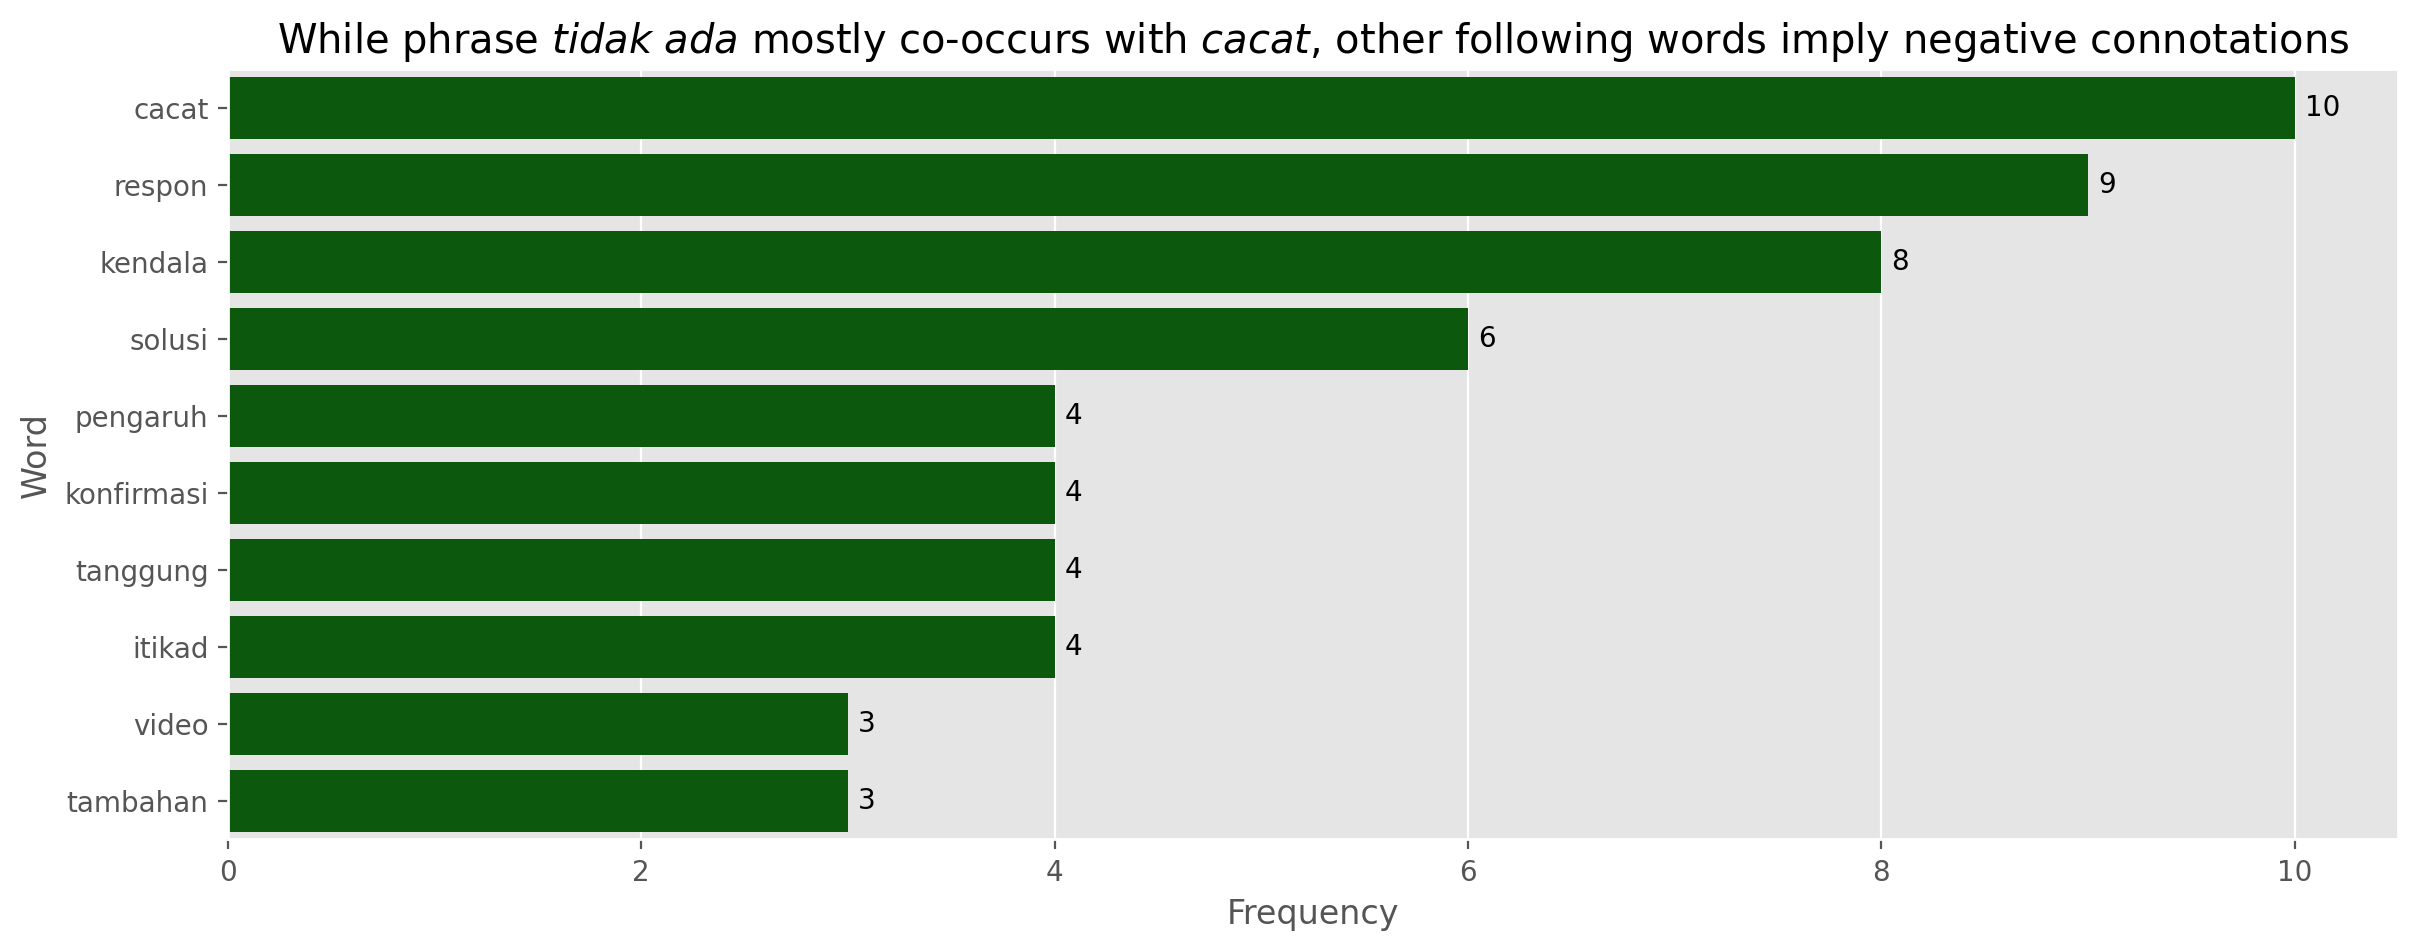

In [92]:
# make bar chart
plt.figure(figsize=(14, 5), dpi=200)
sns.barplot(x='Frequency', y='Word', data=co_occurrence_df.head(10), color='darkgreen')
for index, value in enumerate(co_occurrence_df['Frequency'].head(10)):
    plt.text(value+0.05, index, str(value), va='center')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('While phrase $tidak$ $ada$ mostly co-occurs with $cacat$, other following words imply negative connotations')
plt.show()

In [93]:
# display KWIC for 'tidak ada cacat'
conc_index.print_concordance(['tidak', 'ada', 'cacat'], width=100, lines=10)

Displaying 10 of 10 matches:
nya memuaskan packingnya aman jadi barang tidak ada cacat sama sekali barangnya sudah sampai tidak 
 selamat keadaan buku baik baik saja buku tidak ada cacat dan kekurangan pengiriman cepat packing r
ai dg deskrip yang jual packing bagus dan tidak ada cacat nanti saya mau pesan lagi buku sampai har
nang produknya dipaketkan dengan rapi dan tidak ada cacat recommended pengiriman cepat harganya mur
blewrap juga gaada bukunya original bagus tidak ada cacat sayangnya saja respon dari penjual lama s
baik produknya dipaketkan dengan rapi dan tidak ada cacat recommended pasangnya gampang bahannya ko
t spongenya kirain pas nyampe bener mulus tidak ada cacat nya barang yang di datang tidak sesuai pe
ging rapi pengiriman cepat pesanan sesuai tidak ada cacat packing aman selalu repurchase deh buat p
bawa bawa pengiriman cepat pesanan sesuai tidak ada cacat packing aman coverage nya full proses pes
tetes aja harum barang sampai dengan baik tidak ada cacat ternyata bara

**Comment**: Since the bigram to explore what words frequently accompany *tidak bisa* is *cacat* (broken), the concordance was set with such word combination. In the bar chart of bigrams, *cacat* and *respon* are top two words coming after *tidak bisa*. And based on the concordance lines for *tidak ada cacat* above, the word combinations occur in positive context, indicating positive sentiments even though here we have not associate the review content with the sentiment variable yet. On the contrary to *tidak ada cacat* indicating positive sentiment, the usages of *tidak ada respon* as shown below suggest negative sentiment. Taken altogether, the usages of these word combinations imply diffent sentiments.

In [94]:
# display KWIC for 'tidak ada respon'
conc_index.print_concordance(['tidak', 'ada', 'respon'], width=100, lines=10)

Displaying 9 of 9 matches:
aya juga sudah ajukan cancel pesanan juga tidak ada respon dari penjual pelayanan sangat sangat buru
 kurang baik so sad saya kecewa di tunggu tidak ada respon yang baik dari penjual nya kecewa sama to
otol yang dikirim cm botol penjual dichat tidak ada respon sama sekali sangat mengecewakan penjualny
 tiga pcs tiga kilo sudah dikomplain tapi tidak ada respon yang berarti dana memang dikembalikan seb
kan sudah di tekan tombol on off komplain tidak ada respon tolong jgn jual jam mati rusak atau di ce
dak sesuai deskripsi dan tidak ada solusi tidak ada respon akhir dr si penjual lebih kecil ndak muat
ehingga tidak bisa di pakai pihak penjual tidak ada respon tidak bisa membantu saya sangat kecewa no
 ribu sudah mengirim pesan ke seller tapi tidak ada respon selama lebih dari jam terpaksa saya kasih
itan ada yang tidak rapih pelayanan buruk tidak ada respon warna baju tidak sesuai di wa dan chat vi


#### **3.3.5 Do different sentiments have different patterns of words and word combinations?**
This question is one of most critical point in this project. Not only is it concernd with review contents similar to the previous analysis, but this question also takes sentiments into account. The answer of this question is expected to triangulate the feature importance section later in the model experiments. For instance, we will check whether most important features correspond to thee most frequent words by sentiment here. To this end, we will subset dataset by sentiment class (negative or positive).

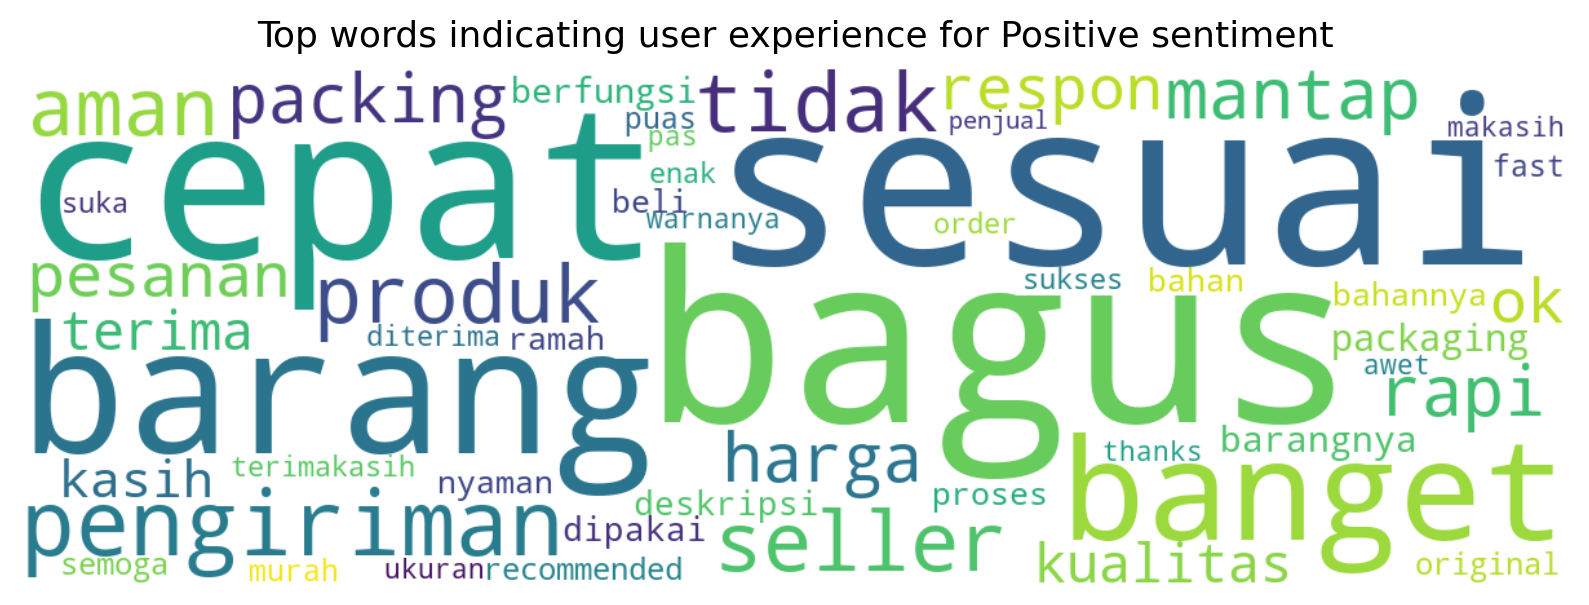

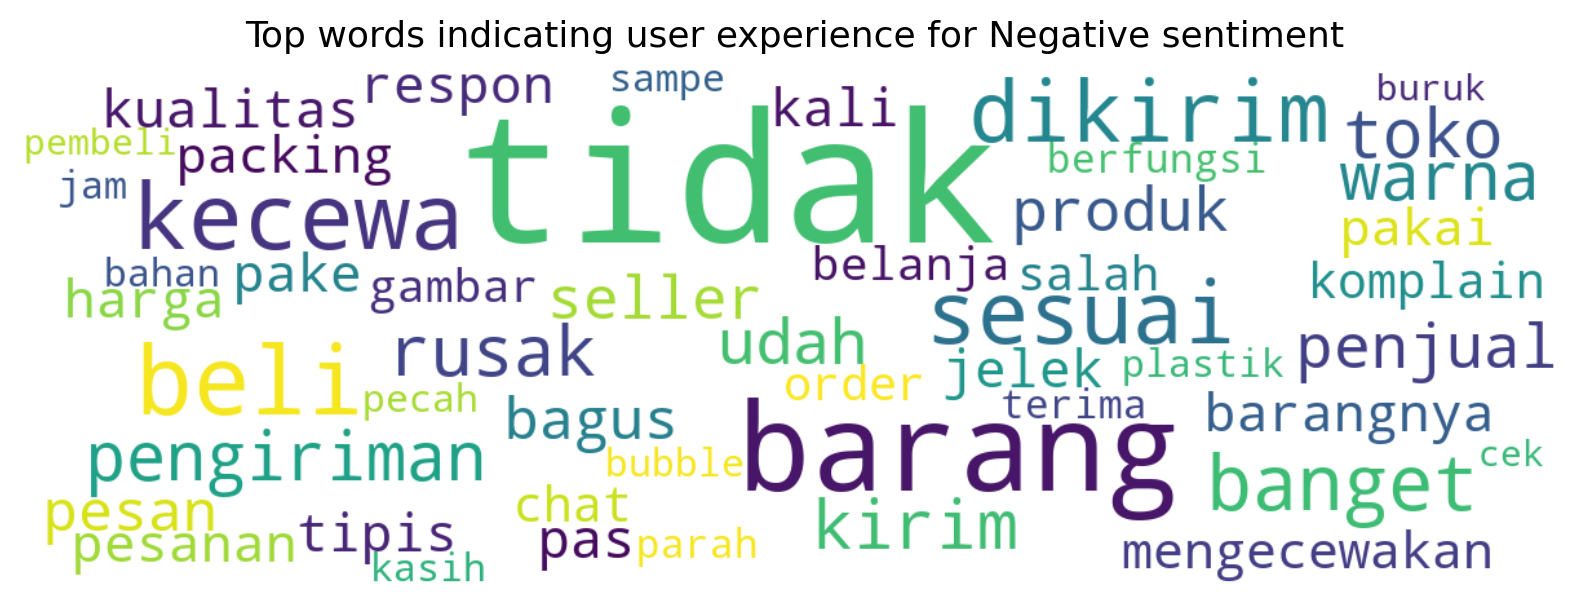

In [95]:
# get unique values from sentiment
sentiments = df['Sentiment'].unique()

for sentiment in sentiments:
    # prepare word counts for the specific sentiment
    all_tokens = [word for tokens in df[df['Sentiment'] == sentiment]['tokens']
                  for word in tokens if word not in stop_words]
    word_counts = Counter(all_tokens)

    # create word cloud
    wordcloud = (WordCloud(width=1200, height=400, background_color='white',
                           max_words=50, prefer_horizontal=1.0)
                 .generate_from_frequencies(dict(word_counts.most_common(50))))

    plt.figure(figsize=(10, 5), dpi=200)
    plt.imshow(wordcloud, interpolation='bilinear', cmap='tab20')
    plt.title(f'Top words indicating user experience for {sentiment} sentiment', size=13, y=1.01)
    plt.axis('off')
    plt.show()

In [110]:
# get top tokens for negative sentiment
negative_tokens = [word for tokens in df[df['Sentiment'] == 'Negative']['tokens']
                   for word in tokens if word not in stop_words]
negative_token_counts = Counter(negative_tokens).most_common(10)
negative_top_tokens = set([token for token, count in negative_token_counts])

# get top tokens for positive sentiment
positive_tokens = [word for tokens in df[df['Sentiment'] == 'Positive']['tokens']
                   for word in tokens if word not in stop_words]
positive_token_counts = Counter(positive_tokens).most_common(10)
positive_top_tokens = set([token for token, count in positive_token_counts])

# words only in each sentiment 
unique_negative_tokens = negative_top_tokens.difference(positive_top_tokens)
unique_positive_tokens = positive_top_tokens.difference(negative_top_tokens)

# find intersection of tokens in all sentiments
common_tokens = negative_top_tokens.intersection(positive_top_tokens)

print(f'Words only in Negative sentiment: \n- {unique_negative_tokens}\n')
print(f'Words only in Positive sentiment: \n- {unique_positive_tokens}\n')
print(f'Common tokens between top-10 negative and positive sentiments: \n- {common_tokens}')

Words only in Negative sentiment: 
- {'beli', 'kecewa', 'rusak', 'dikirim', 'kirim'}

Words only in Positive sentiment: 
- {'produk', 'bagus', 'cepat', 'aman', 'seller'}

Common tokens between top-10 negative and positive sentiments: 
- {'banget', 'pengiriman', 'sesuai', 'barang', 'tidak'}


**Comment**
- At glance, negative and positive sentiments seem to have diffent top words. For example, reviews containing *beli*, *kecewa*, *rusak*, *dikirim*, and *kirim* are usually tagged as negative sentiments while positive sentiments are usually associated with reviews with *produk*, *bagus*, *cepat*, *aman*, and *seller*. 
- In addition to these differences, these sentiments share common words such as *banget*, *pengiriman*, *sesuai*, *barang* and *tidak*. Because these are shared words, it should be checked further during the feature importance in the best models whether the shared words tend to be associated with a certain sentiment.
- To make these similarities and differences, let us take a look at the following bar chart.

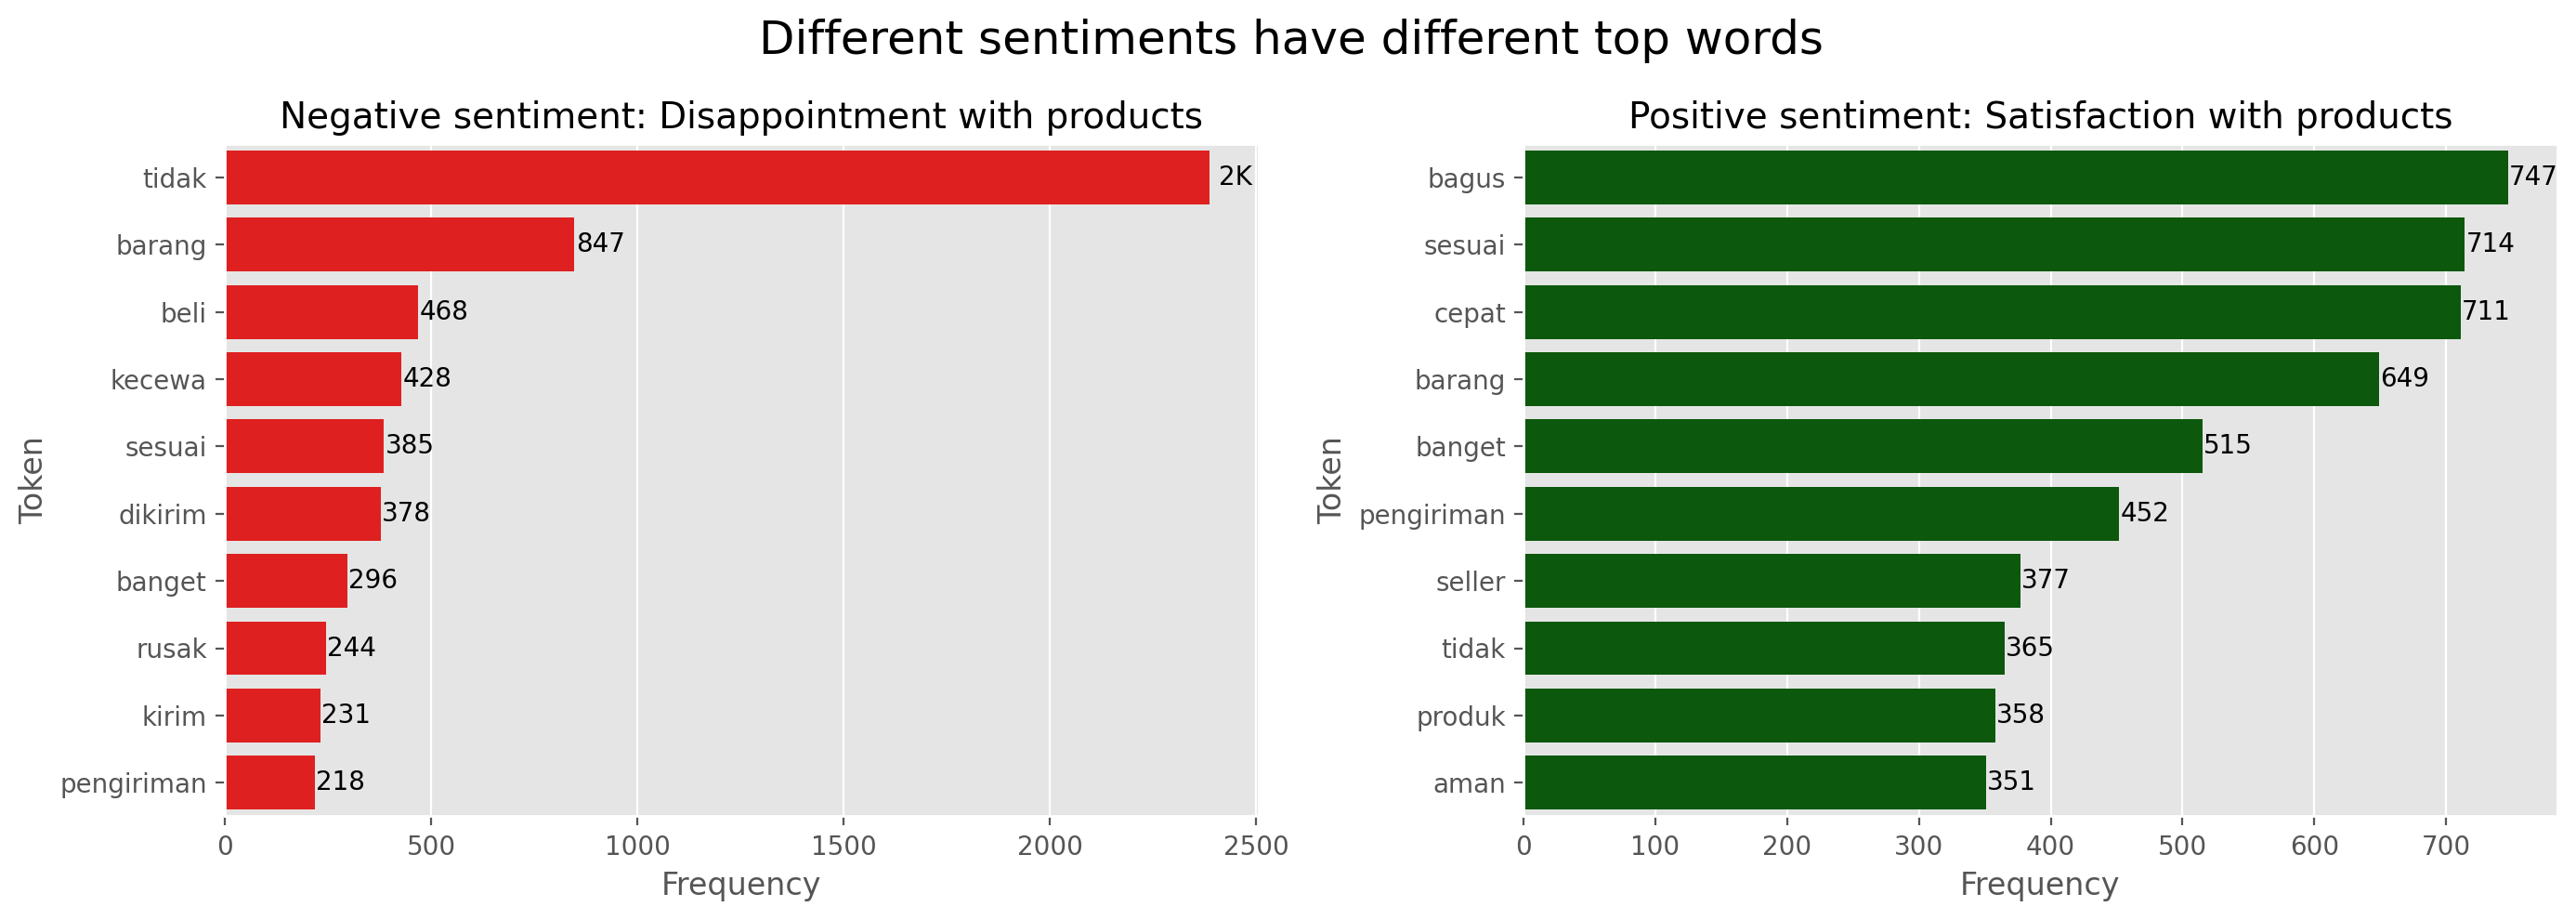

In [112]:
# create subplots: two columns side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), dpi=200)

# plot 1: most frequent tokens for negative sentiment 
all_tokens = [token for sublist in df[df['Sentiment'] == 'Negative']['tokens'] for token in sublist]
token_counts = Counter(all_tokens)
token_df = (pd.DataFrame(token_counts.items(), columns=['token', 'count'])
            .sort_values(by='count', ascending=False))

sns.barplot(x='count', y='token', data=token_df.head(10), color='red', ax=axes[0])
axes[0].set_title('Negative sentiment: Disappointment with products', fontsize=14)
axes[0].set_xlabel('Frequency', fontsize=12)
axes[0].set_ylabel('Token', fontsize=12)

# add labels to each bar 
for p in axes[0].patches:
    count_value = int(p.get_width())
    label = f'{count_value // 1000}K' if count_value >= 1000 else str(count_value)
    axes[0].annotate(label,
                     (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='center', va='center', xytext=(10, 0),
                     textcoords='offset points', fontsize=10)

# plot 2: most frequent tokens for positive sentiment
all_tokens = [token for sublist in df[df['Sentiment'] == 'Positive']['tokens'] for token in sublist]
token_counts = Counter(all_tokens)
token_df = (pd.DataFrame(token_counts.items(), columns=['token', 'count'])
            .sort_values(by='count', ascending=False))

sns.barplot(x='count', y='token', data=token_df.head(10), color='darkgreen', ax=axes[1])
axes[1].set_title('Positive sentiment: Satisfaction with products', fontsize=14)
axes[1].set_xlabel('Frequency', fontsize=12)
axes[1].set_ylabel('Token', fontsize=12)

# add labels to each bar 
for p in axes[1].patches:
    count_value = int(p.get_width())
    label = f'{count_value // 1000}K' if count_value >= 1000 else str(count_value)
    axes[1].annotate(label,
                     (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='center', va='center', xytext=(10, 0),
                     textcoords='offset points', fontsize=10)

plt.suptitle('Different sentiments have different top words', size=18)
plt.subplots_adjust(top=0.85)
plt.tight_layout()
plt.show()

#### **3.3.3 Is there any significant difference between sentiment categories in review length?**
Sometimes, customers tend to write longer reviews when they feel dissatisfied with the products they bought to explain their dissatisfaction (see data analysis for topic modeling project [here](https://nbviewer.org/github/LingAdeu/key-themes-in-user-reviews/blob/main/notebook/01_Data-Analysis.ipynb)). To test whether this phenomenon also occurs in this dataset, we will carry out both descriptive and inferential statistical tests, allowing us to understand patterns in the dataset and draw inference from the sample.

In [118]:
# add column review length (in words)
df['ReviewLength'] = df['CleanReview'].str.split().str.len()

**Comment**: Since there was no review length available in the original dataset, we decided to extract more feature related to review length. The review length can be obtained from column `CleanReview` by firstly tokenize each instance to word level, and get the length of the list by words. The output of this feature extraction is integers.

In [134]:
# get descriptive statistics
display(df['ReviewLength'].describe().to_frame().transpose())
display(df.groupby('Sentiment').agg(func={'ReviewLength':'describe'}))

count       mean        std  min  25%   50%   75%    max
ReviewLength  5393.0  15.888003  15.438391  1.0  7.0  12.0  20.0  178.0

ReviewLength                                                   
                 count       mean        std  min  25%   50%   75%    max
Sentiment                                                                
Negative        2817.0  18.678736  18.194774  1.0  7.0  13.0  24.0  178.0
Positive        2576.0  12.836180  10.918638  1.0  6.0  10.0  17.0  157.0

**Comment**: Unexpectedly, negative and positive sentiments do not seem to have different distributions. The central tendency measures by mean and median suggest they share commonalities. The mean (18.67 vs 12.83) and median values (24 vs 17) of those two sentiment classes are close to each other so we don't have enough evidence to this point that different sentiment classes will have substantially different word length. In order to make the similarities more explicit, let us consider the overlay histogram below.

In [121]:
# filter data by Sentiment
neg_sent = df[df['Sentiment'] == 'Negative']['ReviewLength']
pos_sent = df[df['Sentiment'] == 'Positive']['ReviewLength']

# get median values
neg_sent_median = neg_sent.median()
pos_sent_median = pos_sent.median()

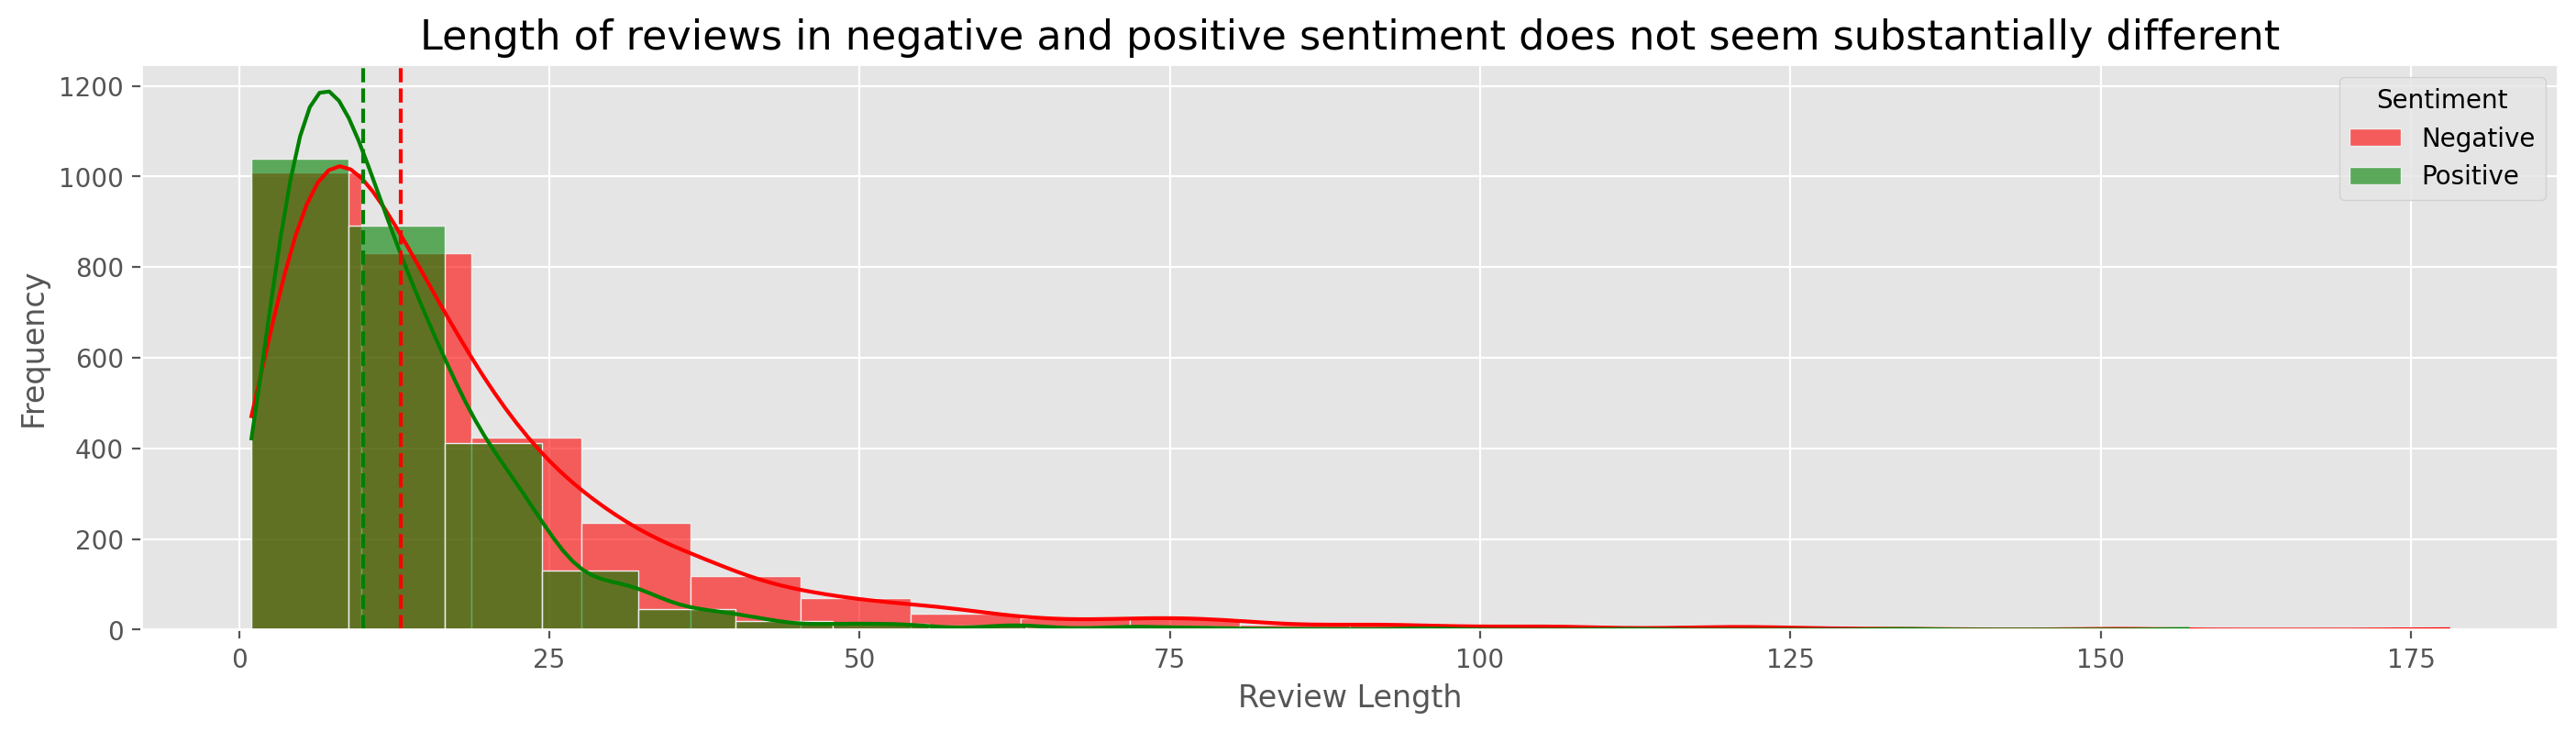

In [122]:
# create the overlay histogram
plt.figure(figsize=(17, 4), dpi=200)

# histogram for negative sentiment
sns.histplot(neg_sent, bins=20, color='red', kde=True, label='Negative', alpha=0.6)
sns.histplot(pos_sent, bins=20, color='green', kde=True, label='Positive', alpha=0.6)
plt.axvline(neg_sent_median, color='red', linestyle='--')
plt.axvline(pos_sent_median, color='green', linestyle='--')

plt.title('Length of reviews in negative and positive sentiment does not seem substantially different',
          fontsize=16)
plt.xlabel('Review Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.legend(title='Sentiment')
plt.show()

**Comment**
- There are two histograms in the plot, representing negative and positive sentiments in the customer reviews. Confirming the descriptive statistical output, the central tendencies of these two histograms, especially by medians, are very close so it is hard to say that reviews with negative sentiments tend to be lengthier. Drawing from the sample, even if we use inferential statistics to make inference about the population (all reviews, including the future reviews), the output will possibly be not significantly different. And even if significantly different, the effect size (rank biserial or $r$) will be most likely to be minor.
- Statistical test for comparing group difference here is Mann-Whitney *U* (rank-sum difference) test since the distribution is positively skewed or not following normal distribution (bell-shaped curve). And the data type for sentiment is nominal, not ordinal, so Wilcoxon test is dropped from out list of options. If the distribution shapes of both groups are normal, then *t*-test of independent samples can be chosen.
- Unlike parameteric tests, Mann-Whitney *U* test uses rank of the values instead of the values themselves, making the test more robust to outliers.
- The null hypothesis ($H_0$) of Mann-Whitney *U* test is no difference between two groups. Thus, when the *p*-value is lower than the alpha at 0.05, the $H_0$ can be rejected, indicating that the two groups are significantly different.

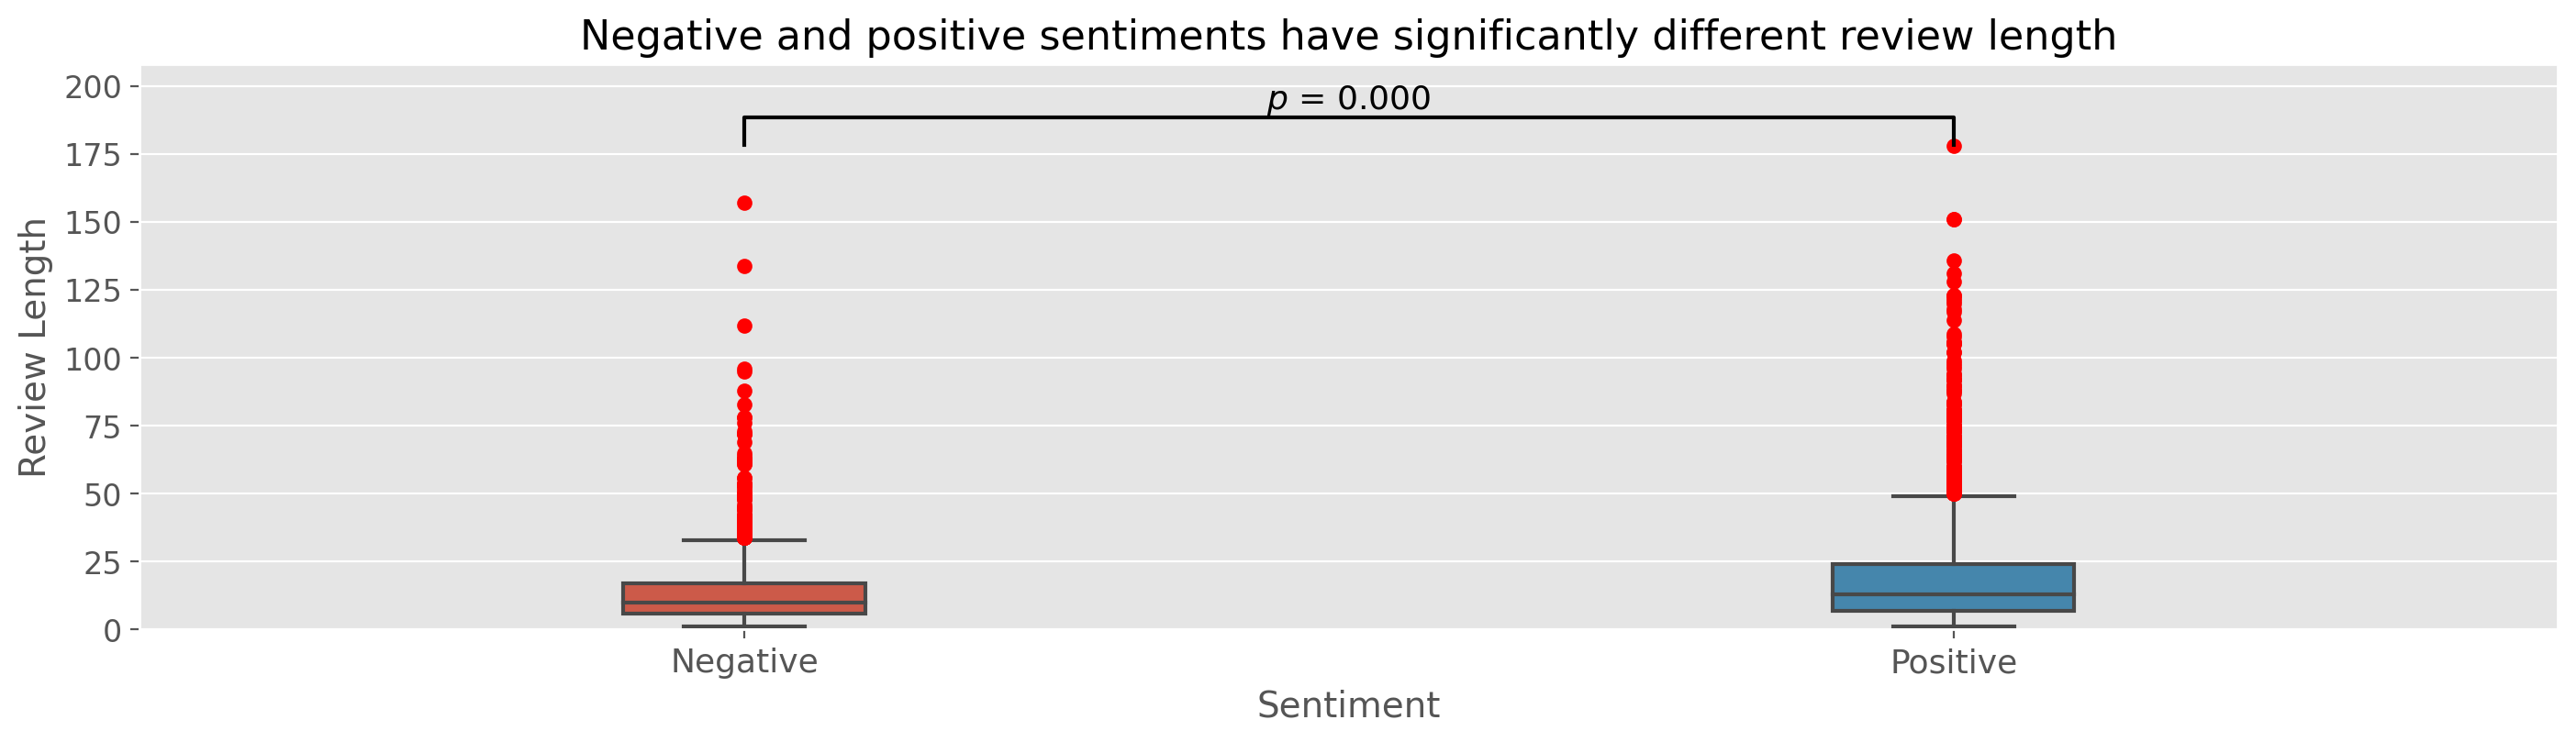

In [135]:
# Mann-Whitney U test
neg_sent = df[df['Sentiment'] == 'Negative']['ReviewLength']
pos_sent = df[df['Sentiment'] == 'Positive']['ReviewLength']
stat, p_value = mannwhitneyu(neg_sent, pos_sent, alternative='two-sided')

# create box plot
plt.figure(figsize=(17, 4), dpi=200)
ax = sns.boxplot(x='Sentiment', y='ReviewLength', data=df, width=0.2,
                 flierprops=dict(marker='.', markerfacecolor='red', markeredgecolor='red', 
                                 alpha=1, markersize=10)) 

# adjust x-tick labels and title
ax.set_ylim(0, df['ReviewLength'].max() + 30)  
ax.set_xticklabels(['Negative', 'Positive'], ha='center', size=13)
ax.set_ylabel('Review Length', fontsize=14) 
ax.set_xlabel('Sentiment', fontsize=14)
ax.tick_params(axis='y', labelsize=12)  
plt.title('Negative and positive sentiments have significantly different review length', fontsize=16)

# add p-value annotation
x1, x2 = 0, 1
y, h, col = df['ReviewLength'].max() + 0.5, 10, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1 + x2) * 0.5, y + h, f"$p$ = {p_value:.3f}", ha='center', 
         va='bottom', color=col, size=13)

plt.show()

**Comment**
- Interestingly, negative and positive sentiments are significantly different in terms of review length. Reviews with positive sentiments have higher median review length than those with negative sentiment. However, it is unclear yet if such significant result has pratical significance or deserves more attention.
- To compute the rank-biserial effect size, the following formula can be used:
- Using mean Ranks:
$$r_{rb} = \frac{\bar{R}_1 - \bar{R}_2}{n}$$
- $\bar{R}_1$ is the mean rank of group 1, $\bar{R}_2$ is the mean rank of group 2, and $n$ is the total sample size $(n_1 + n_2)$. Kindly note that the difference $\bar{R}_1 - \bar{R}_2$ represents the difference in mean ranks. It can also be related to the U statistic as follows:
$$\bar{R}_1 - \bar{R}_2 = \frac{2U}{n_1 + n_2}$$
- Alternatively, the formula with U statistic can be expressed as:
$$r_{rb} = \frac{U - \frac{n_1 \cdot n_2}{2}}{n_1 \cdot n_2}$$
- Here, $U$ is the Mann-Whitney U statistic, $n_1$ is the sample size of group 1, and $n_2$ is the sample size of group 2. The last formula is what we implement in the code below.

In [129]:
# function to calculate effect size
def rank_biserial_effectsize(u_statistic, n1, n2):
    return (u_statistic - (n1 * n2 / 2)) / (n1 * n2) 

# function to compute bootstrap CIs
def bootstrap_ci(data1, data2, num_iterations=1000, alpha=0.05):
    boot_stats = []
    n1, n2 = len(data1), len(data2)
    
    for _ in range(num_iterations):
        sample1 = resample(data1)
        sample2 = resample(data2)
        u_statistic, _ = mannwhitneyu(sample1, sample2, alternative='two-sided')
        effect_size = rank_biserial_effectsize(u_statistic, n1, n2)
        boot_stats.append(effect_size)
    
    boot_stats = np.array(boot_stats)
    lower_bound = np.percentile(boot_stats, 100 * alpha / 2)
    upper_bound = np.percentile(boot_stats, 100 * (1 - alpha / 2))
    
    return lower_bound, upper_bound

In [130]:
# split data by sentiment
data_group1 = df[df['Sentiment'] == 'Positive']['ReviewLength']
data_group2 = df[df['Sentiment'] == 'Negative']['ReviewLength']

# calculate Mann-Whitney U statistic
u_statistic, p_value = mannwhitneyu(data_group1, data_group2, alternative='two-sided')

# calculate effect size
n1, n2 = len(data_group1), len(data_group2)
effect_size = rank_biserial_effectsize(u_statistic, n1, n2)

# calculate bootstrap confidence intervals
ci_lower, ci_upper = bootstrap_ci(data_group1, data_group2)

In [131]:
# create df to display the results
stat_output = pd.DataFrame({
    'U_stat': [u_statistic], 
    'p-value': [p_value],
    'effect_size': [effect_size],
    '95%CI': [[round(ci_lower, 3), round(ci_upper, 3)]]
}).round(3)

display(stat_output)

U_stat  p-value  effect_size             95%CI
0  2944638.5      0.0       -0.094  [-0.109, -0.079]

**Comment**: The Mann-Whitney U test revealed a statistically significant difference in review lengths between negative and positive sentiments (U = 2944638.5, $p$ < 0.005), indicating that this difference is unlikely due to chance but the rank-biserial effect size ($r_{rb}$: −0.094 shows that the difference is small in magnitude. This suggests that while negative reviews are, on average, shorter than positive ones, the practical significance of this finding is minimal. In other words, although the difference is statistically real, its actual impact is minor, and may not warrant substantial action based on review length alone.

In [120]:
Q1 = df['ReviewLength'].quantile(0.25)
Q3 = df['ReviewLength'].quantile(0.75)
IQR = Q3 - Q1
upper_threshold = Q3 + 1.5 * IQR
lower_threshold = Q1 - 1.5 * IQR
outliers = df[(df['ReviewLength'] < lower_threshold) | (df['ReviewLength'] > upper_threshold)]
print(f'Total outliers: {len(outliers)}')
display(outliers[['CleanReview', 'Sentiment', 'ReviewLength']].head())

Total outliers: 330


CleanReview Sentiment  ReviewLength
41  jelek yang pasti jauh dari ori mousepad jadi t...  Negative            58
45  pas beli nanya dulu tipe untuk macbook pro inc...  Negative            50
51  kecewa sama toko official ini tidak tau kenapa...  Negative            90
66  tidak bisa di register call center dan team or...  Negative            92
68  janji bisa kirim instant segera karena kita ma...  Negative           120

**Comment**: As above we indicated outliers in the dataset, particularly for review length, with red dots beyond the upper whiskers, here we show the instances which are considered outliers with $n$: 330. This insights adds more information about the review length in which some customers provided longer reviews to tell their experience after receiving their products from Tokopedia.

#### **3.3.3 How is satisfaction or dissatisfaction rate reflected in the reviews?**
Prior to this section, we have shown that satisfaction levels are closely associated with sentiment categories. For this reasons, we will take a look at how the satisfaction levels interact with the main feature, namely review content. This analysis will center around the top words by the number of reviews, focusing on the the lower end of the satisfaction score (representing dissatisfaction) and the higher end of the score (representing satisfaction). For this reason, rating scores in the middle are not considered.

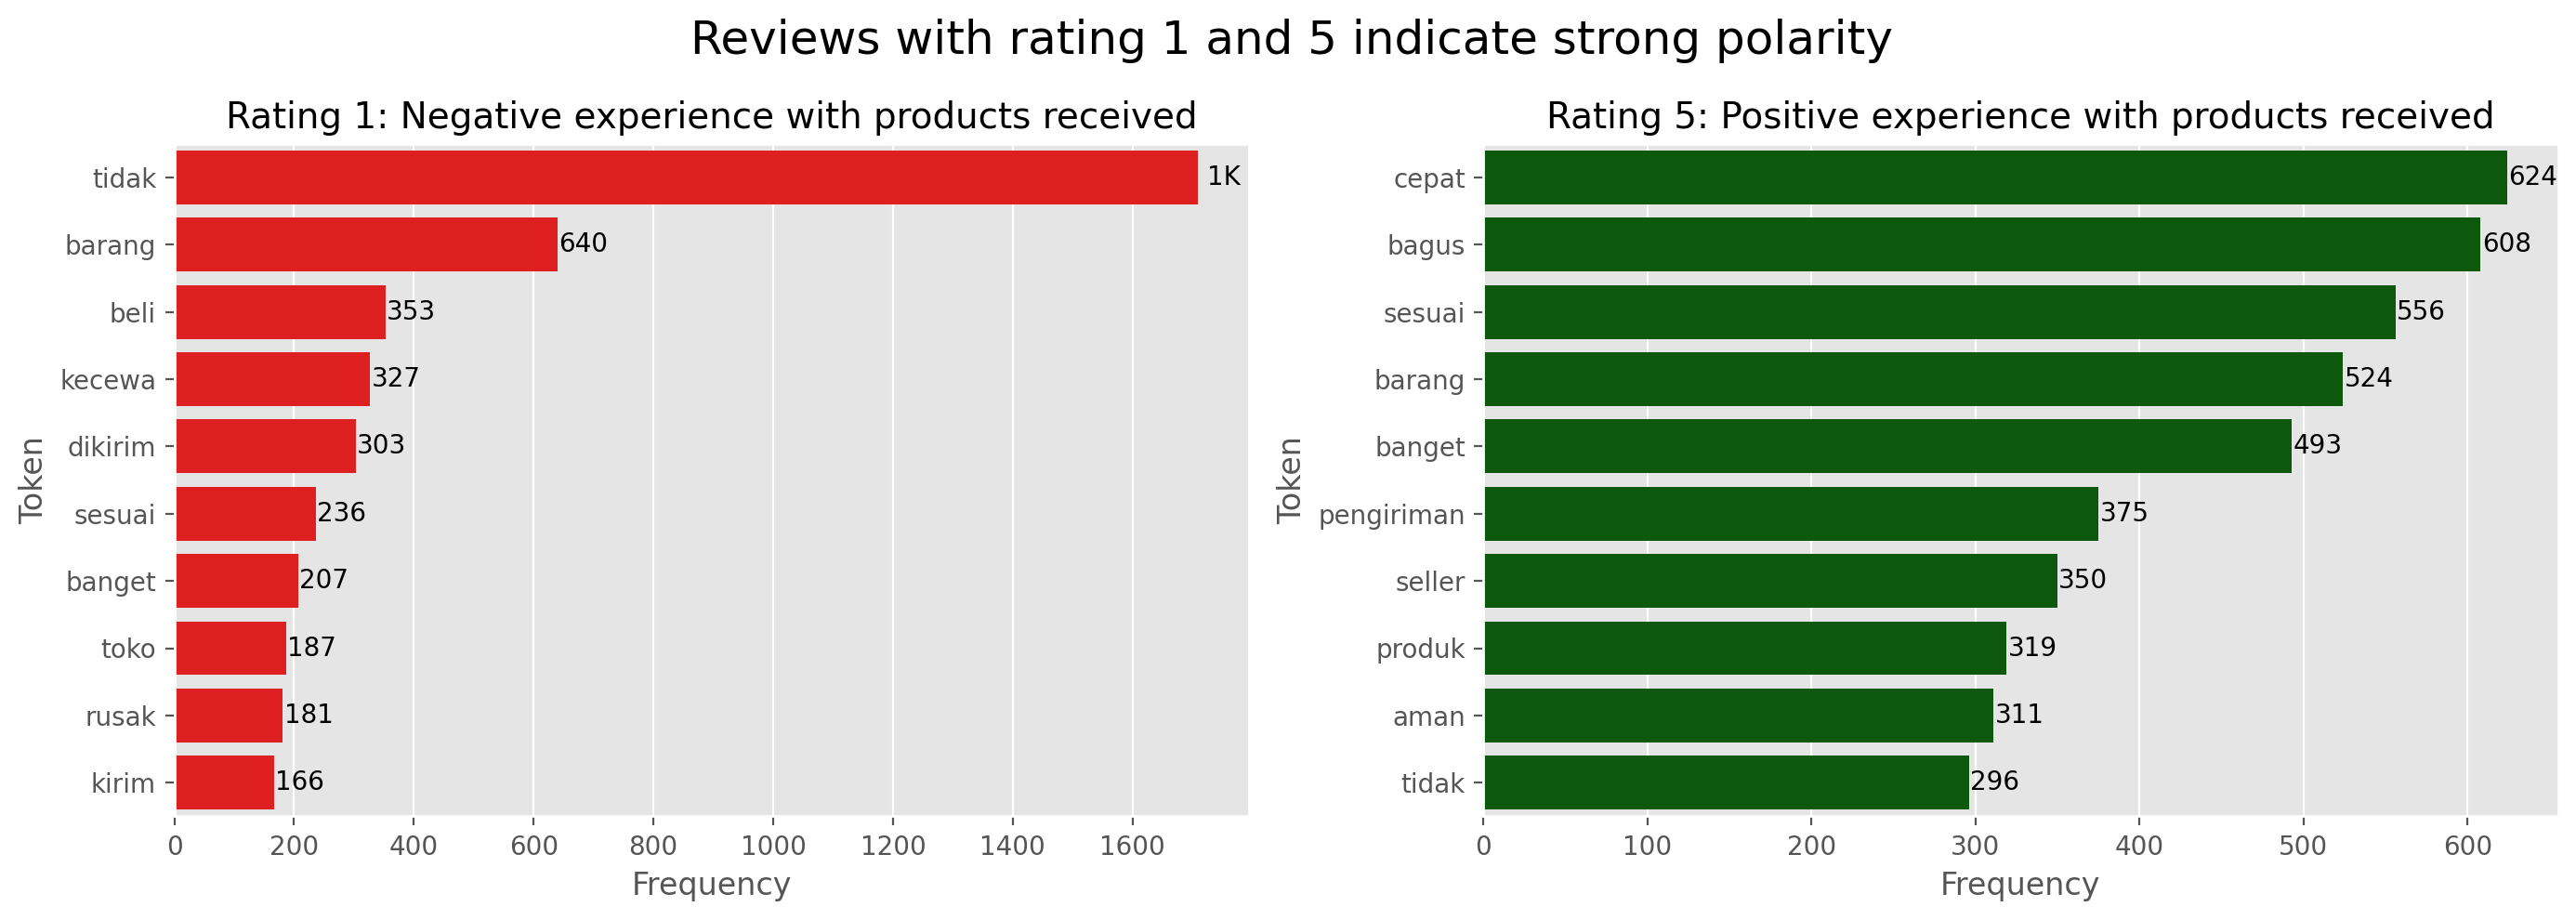

In [215]:
# create subplots: two columns side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), dpi=200)

# plot 1: most frequent tokens for score 1 (on the left)
all_tokens = [token for sublist in df[df['CustomerRating'] == 1]['tokens'] for token in sublist]
token_counts = Counter(all_tokens)
token_df = (pd.DataFrame(token_counts.items(), columns=['token', 'count'])
            .sort_values(by='count', ascending=False))

sns.barplot(x='count', y='token', data=token_df.head(10), color='red', ax=axes[0])
axes[0].set_title('Rating 1: Negative experience with products received', fontsize=14)
axes[0].set_xlabel('Frequency', fontsize=12)
axes[0].set_ylabel('Token', fontsize=12)
for p in axes[0].patches:
    count_value = int(p.get_width())
    label = f'{count_value // 1000}K' if count_value >= 1000 else str(count_value)
    axes[0].annotate(label,
                     (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='center', va='center', xytext=(10, 0),
                     textcoords='offset points', fontsize=10)

# plot 2: most frequent tokens for score 5 (on the right)
all_tokens = [token for sublist in df[df['CustomerRating'] == 5]['tokens'] for token in sublist]
token_counts = Counter(all_tokens)
token_df = (pd.DataFrame(token_counts.items(), columns=['token', 'count'])
            .sort_values(by='count', ascending=False))

sns.barplot(x='count', y='token', data=token_df.head(10), color='darkgreen', ax=axes[1])
axes[1].set_title('Rating 5: Positive experience with products received', fontsize=14)
axes[1].set_xlabel('Frequency', fontsize=12)
axes[1].set_ylabel('Token', fontsize=12)
for p in axes[1].patches:
    count_value = int(p.get_width())
    label = f'{count_value // 1000}K' if count_value >= 1000 else str(count_value)
    axes[1].annotate(label,
                     (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='center', va='center', xytext=(10, 0),
                     textcoords='offset points', fontsize=10)

plt.suptitle('Reviews with rating 1 and 5 indicate strong polarity', 
             size=18)
plt.tight_layout()
plt.show()

**Comment**: Reviews with rating score 1 are predominated by negation mark *tidak*. Even though reviews with rating score 5 also contains *tidak*, the frequency of ocurrences is approximately three times less than those with rating score 1. The commonality of negation marker *tidak* in reviews with rating score 1 might indicate mismatch between expectations and the reality of products the customers received. Besides the frequent cases of *tidak*, it appears that reviews with rating score 1 and 5 have distinct top words in which those with rating 1 tend to convey negative sentiments whereas reviews with rating 5 are more positive with words such as *cepat*, *bagus*, *sesuai*, and *aman*. Therefore, these frequent words represent clearly indicate distinct attitudes about the product. 

In [140]:
# build separate corpora
rating1 = ' '.join(df[df['CustomerRating'] == 1]['CleanReview'].tolist())
rating5 = ' '.join(df[df['CustomerRating'] == 5]['CleanReview'].tolist())

# build concordance index
conc_index1 = ConcordanceIndex(nltk.word_tokenize(rating1))
conc_index5 = ConcordanceIndex(nltk.word_tokenize(rating5))

In [141]:
# display the KWIC
conc_index1.print_concordance('tidak', width=100, lines=10)

Displaying 10 of 1709 matches:
k jelek yang pasti jauh dari ori mousepad jadi tidak bisa dipakai kl di charger jadi getar parah ba
 dipakai kl di charger jadi getar parah barang tidak sesui foto kayak barang lapak sebelah yang har
i lg walaupun sedikit mahal ternyata barangnya tidak sama dengan order sebelumnya tidak bisa di pak
a barangnya tidak sama dengan order sebelumnya tidak bisa di pakai kecewa parah nggk berkah jualan 
a parah nggk berkah jualan gitu kecewa penjual tidak tanggung jawab komplen berhari gada solusi pas
 ya yang ngejual kecewa gamau lagi beli disini tidak tanggung jawab barang sampai terlalu lama pada
anja di tempat kamu lain di pesan lain dikirim tidak ada tissue pembersih atau alat bantuan lainnya
sang sangat kecewa salah beli barang tapi toko tidak ada kompromi sama sekali padahal barang masih 
error dan hilang kecewa sama toko official ini tidak tau kenapa pesenan pertama tidak dikonfirmasi 
 official ini tidak tau kenapa pesenan pertama tidak dikonfirmasi sam

**Comment**: As shown above (rating 1) and below (rating 5), reviews with rating score 1 and 5 have opposite sentiments based on the use of *tidak*. For this reason, negation marker *tidak* cannot be a sole definitive factor for determining whether a review has negative or positive. The negation marker should be interpreted in context. But this conclusion still do not negate the fact that reviews with rating score 1 has much higher numnber of *tidak* than those with rating score 5.

In [142]:
# display the KWIC
conc_index5.print_concordance('tidak', width=100, lines=10)

Displaying 10 of 296 matches:
epat sampai kualitas bagus dan pengiriman aman tidak ada yang pecah manstapu bagus berkualitas sesu
bar dan memberikan berbagai saran yang pembeli tidak tahu mantap lah barang sampai dengan cepat pac
i dengan cepat packingnya rapi dan amat sekali tidak ada bagian acrylic yang pecah berfungsi dengan
 pelayanan sangat baik mantap laptop jadi adem tidak cpt panas memory sudah saya pasang ada keping 
okoknya hehehehehe mantab respon cepat pesanan tidak mengecewakan rekomended buat belanja spare par
am sore masih di gas mantap banget kualitasnya tidak usah diragukan lagi cakep produk nya rekomen b
cakep bet dah mau duduk aja di kursi ini sampe tidak mau berdiri lagi rasanya overall memuaskan lay
emuaskan layar bagus walau menurut saya ipsnya tidak sebagus ips tv warna sudah bagus tidak oversat
 ipsnya tidak sebagus ips tv warna sudah bagus tidak oversaturated brightness sangat terang buat di
twarenya mungkin lebih bagus lagi jadi setting tidak perlu lewat tombo

## **4 Conclusions**
In summary, our project aims to develop a machine learning model to monitor customer product reviews, enabling store owner to understand what their customer feel about their products and services, and therefore, supporting the Product Manager to develop products. This section is the exploratory phase of our project, focusing more on analyzing key variables, namely customer reviews and sentiments, and relating them to different variables to obtain in-depth understanding of customer reviews along with the overall customer perception. Using word frequencies and n-grams, we found that the distribution between sentiment classes is overall balanced so no resampling technique (e.g., random oversampling, SMOTE, or ADASYN) needs to be implemented in the pipeline of the predictive modeling. Sentiment appears to be significantly associated with different variables such as emotions, customer satisfaction rating scores. These high associations imply the presence or absence of sentiments depend on the value of emotions or CSAT scores. While price can be implicitly related to sentiment in which high-valued products lead to high expectations, we found that price does not have strong relationship with sentiment. 

We also explored the usage of words and word combinations with term frequencies and n-grams, highlighting user experience with product delivery and selling service. Among the top words, negation marker *tidak* has the highest frequency of occurrences, indicating potential problems related to underexpected products when received by the customers. However, it is important to note that *tidak* does not always indicate negative experiences since we revealed both negative and positive connotations in context where the negative markers were found, especialy when we compared the usage of *tidak* in low and high end of rating scores. Equally important, negative and positive sentiments have unique top words, signaling customer attitudes toward the products or selling services.

For predictive modeling phase, the key takeaways here includes: (1) no need to balance the dataset as the target class distribution is already balanced. (2) The data cleaning process, especially for the review contents, seems to be effective. Majority of contractions common in written Indonesian computer-mediated communication have been captured and normalize to their original forms. For this reason, the dataset used in the data exploration phase can be utilized right away for modeling the sentiment. (3) Term Frequency-Inverse Document Frequncy (TF-IDF) can be chosen over bag-of-words for the language representation during feature engineering as previously, different sentiments appear to have different selection of words (unique to each class). TF-IDF may help in discriminating words or features for negative and positive sentiments because it takes both uniqueness of words in a specific sentiment category but rare in other sentiment category.

In [220]:
# store clean data
df.to_csv('../data/cleaned_data.csv', index=False)
print('Clean dataset has been saved!')

Clean dataset has been saved!


<h1 style='color:orange; text-align:center; font-weight:bold'>---END---</h1>

### **Do different product categories tend to have different ratings?**

In [221]:
category_df = (df.groupby('Category', as_index=False)
               .agg(func={'CustomerRating':'median'})
               .sort_values(by='CustomerRating', ascending=False))

# Separate the top 5 highest and lowest-rated categories
highest_rated = category_df.nlargest(5, 'CustomerRating')
lowest_rated = category_df.nsmallest(5, 'CustomerRating')

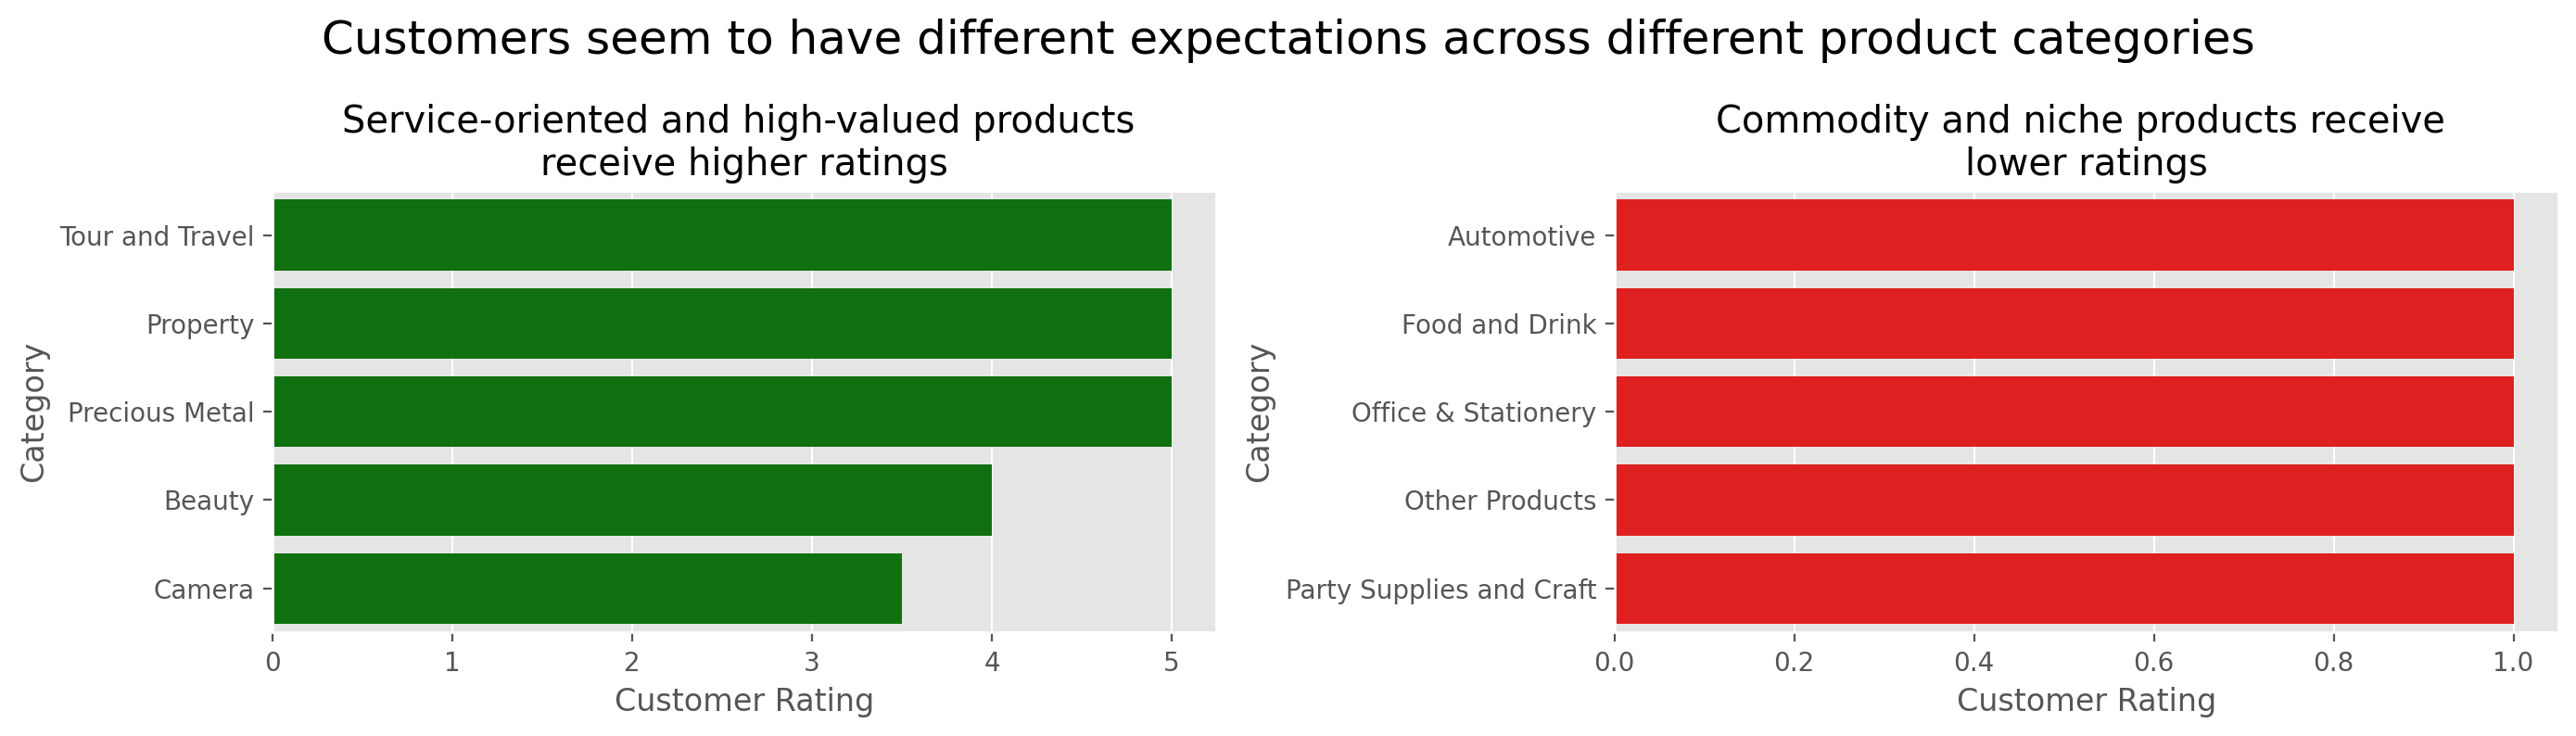

In [222]:
# Set up the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(14, 4), dpi=200)

# Plot the highest-rated categories
sns.barplot(x='CustomerRating', y='Category', data=highest_rated, ax=axes[0], color='green')
axes[0].set_title('Service-oriented and high-valued products \nreceive higher ratings')
axes[0].set_xlabel('Customer Rating')
axes[0].set_ylabel('Category')

# Plot the lowest-rated categories
sns.barplot(x='CustomerRating', y='Category', data=lowest_rated, ax=axes[1], color='red')
axes[1].set_title('Commodity and niche products receive \nlower ratings')
axes[1].set_xlabel('Customer Rating')
axes[1].set_ylabel('Category')

# Adjust layout and display
plt.suptitle('Customers seem to have different expectations across different product categories', size=18)
plt.tight_layout()
plt.show()

Service-Oriented Products generally receive higher ratings, possibly due to higher customer expectations being met.
Fashion, Household, and Electronics products tend to have more variability in customer satisfaction, leading to mid-range ratings.
Commodity and Niche Products receive lower ratings, suggesting customer dissatisfaction is more common, possibly due to unmet expectations or inconsistent quality.

In [223]:
# Combine the highest and lowest rated categories
combined_ls = list(highest_rated['Category'].values) + list(lowest_rated['Category'].values)

# Retrieve the count of occurrences for the combined categories
category_cnt = df.groupby('Category').size().reset_index(name='count').sort_values(by='count', ascending=False)

# Filter the categories that are in the combined list
filtered_category_cnt = category_cnt[category_cnt['Category'].isin(combined_ls)]

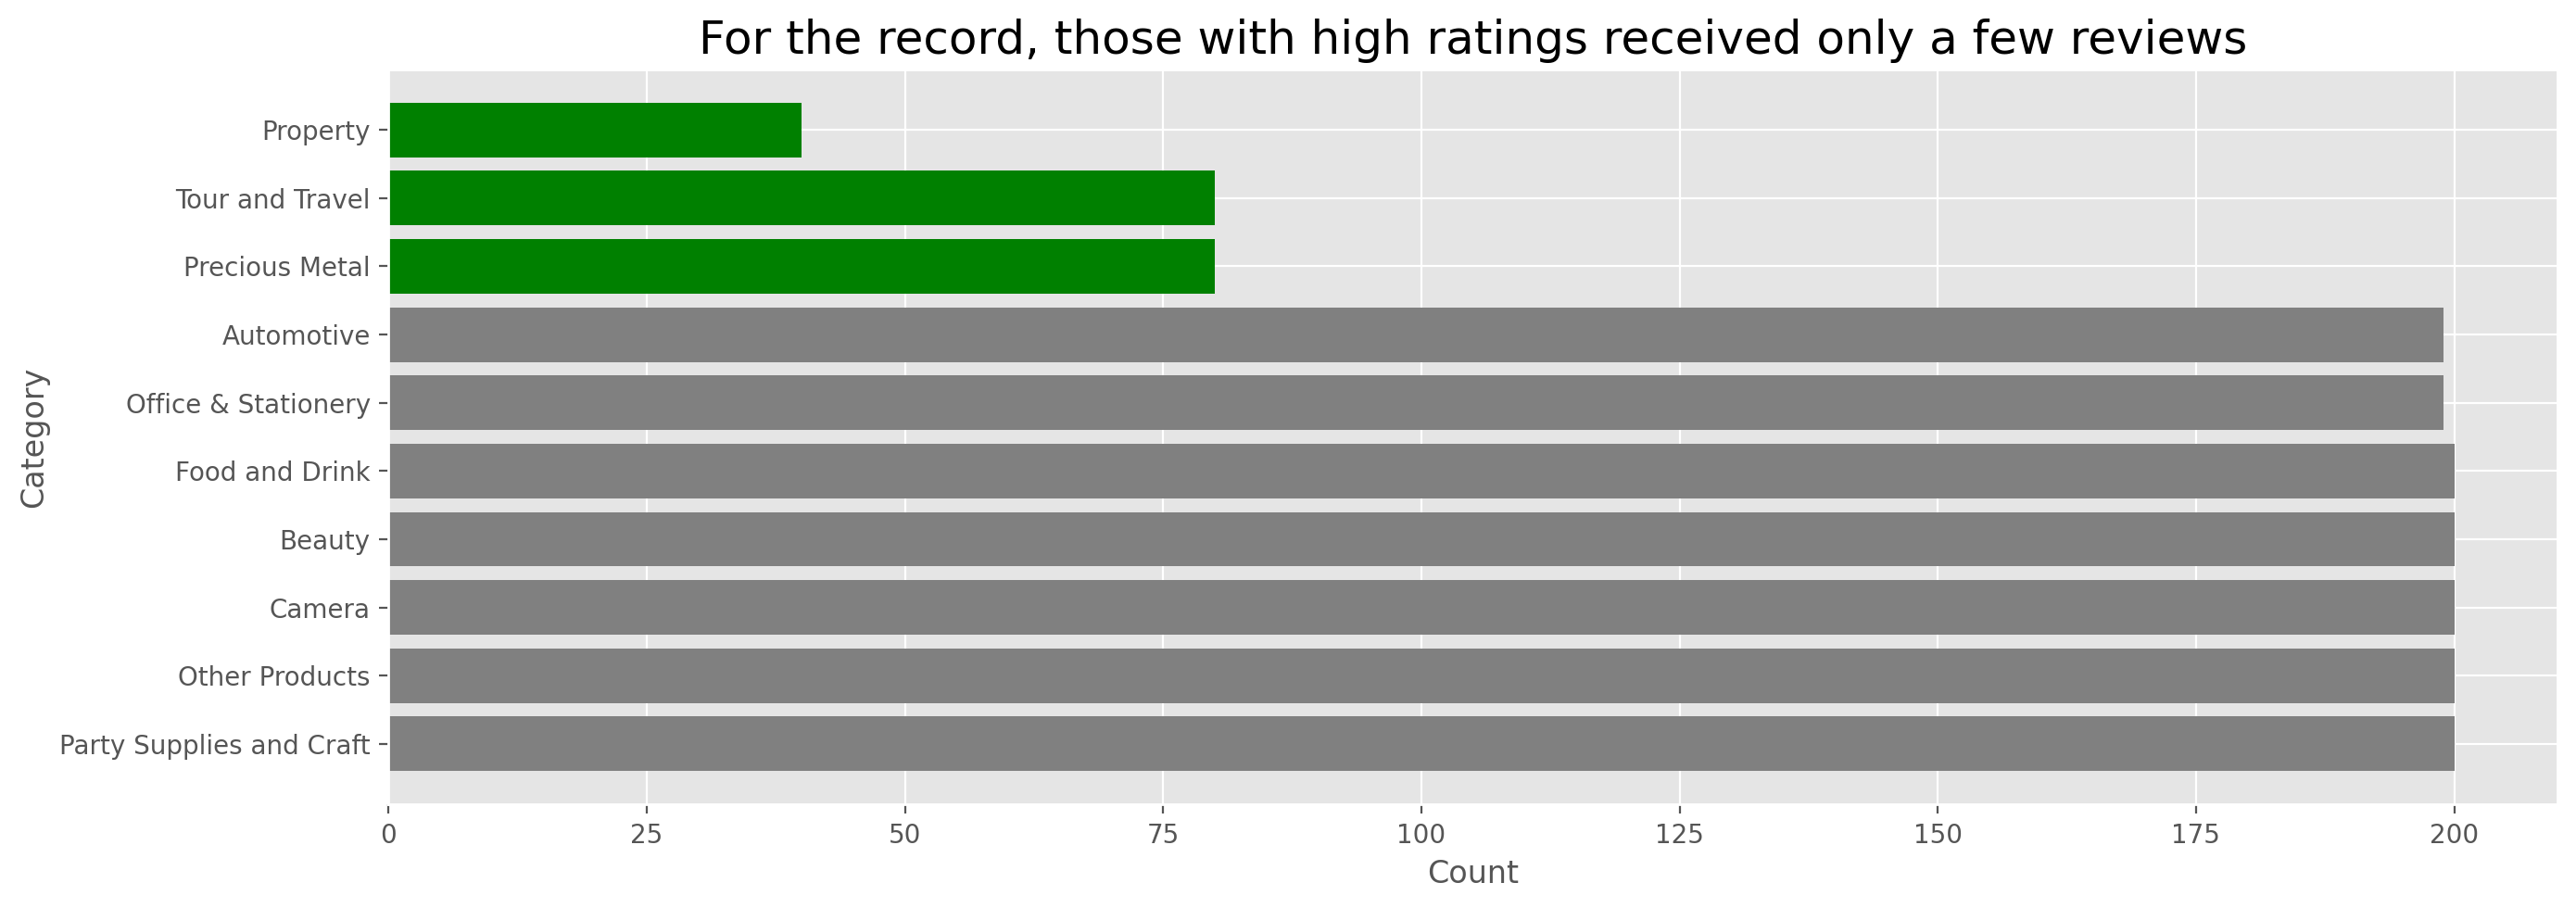

In [224]:
# Define colors for highlighted categories
highlight_categories = ['Property', 'Tour and Travel', 'Precious Metal']
colors = ['grey' if category not in highlight_categories else 'green' for category in filtered_category_cnt['Category']]

# Create a horizontal bar chart
plt.figure(figsize=(14, 5), dpi=200)
plt.barh(filtered_category_cnt['Category'], filtered_category_cnt['count'], color=colors)

# Add labels and title
plt.xlabel('Count')
plt.ylabel('Category')
plt.title('For the record, those with high ratings received only a few reviews', size=18)

# Display the chart
plt.tight_layout()
plt.show()

In [274]:
# init CountVectorizer for bigrams and trigrams
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), token_pattern=r'\b\w+\b')
trigram_vectorizer = CountVectorizer(ngram_range=(3, 3), token_pattern=r'\b\w+\b')

# Fit and transform the reviews
bigram_X = bigram_vectorizer.fit_transform(df['CleanReview'])
trigram_X = trigram_vectorizer.fit_transform(df['CleanReview'])

# Get n-gram counts
bigram_counts = bigram_X.toarray().sum(axis=0)
trigram_counts = trigram_X.toarray().sum(axis=0)
bigram_names = bigram_vectorizer.get_feature_names_out()
trigram_names = trigram_vectorizer.get_feature_names_out()

# Create DataFrames for n-grams and their counts
bigram_df = pd.DataFrame({'ngram': bigram_names, 'count': bigram_counts})
trigram_df = pd.DataFrame({'ngram': trigram_names, 'count': trigram_counts})

# Filter for bigrams and trigrams that have counts greater than 0
bigram_df = bigram_df[bigram_df['count'] > 0].sort_values(by='count', ascending=False)
trigram_df = trigram_df[trigram_df['count'] > 0].sort_values(by='count', ascending=False)

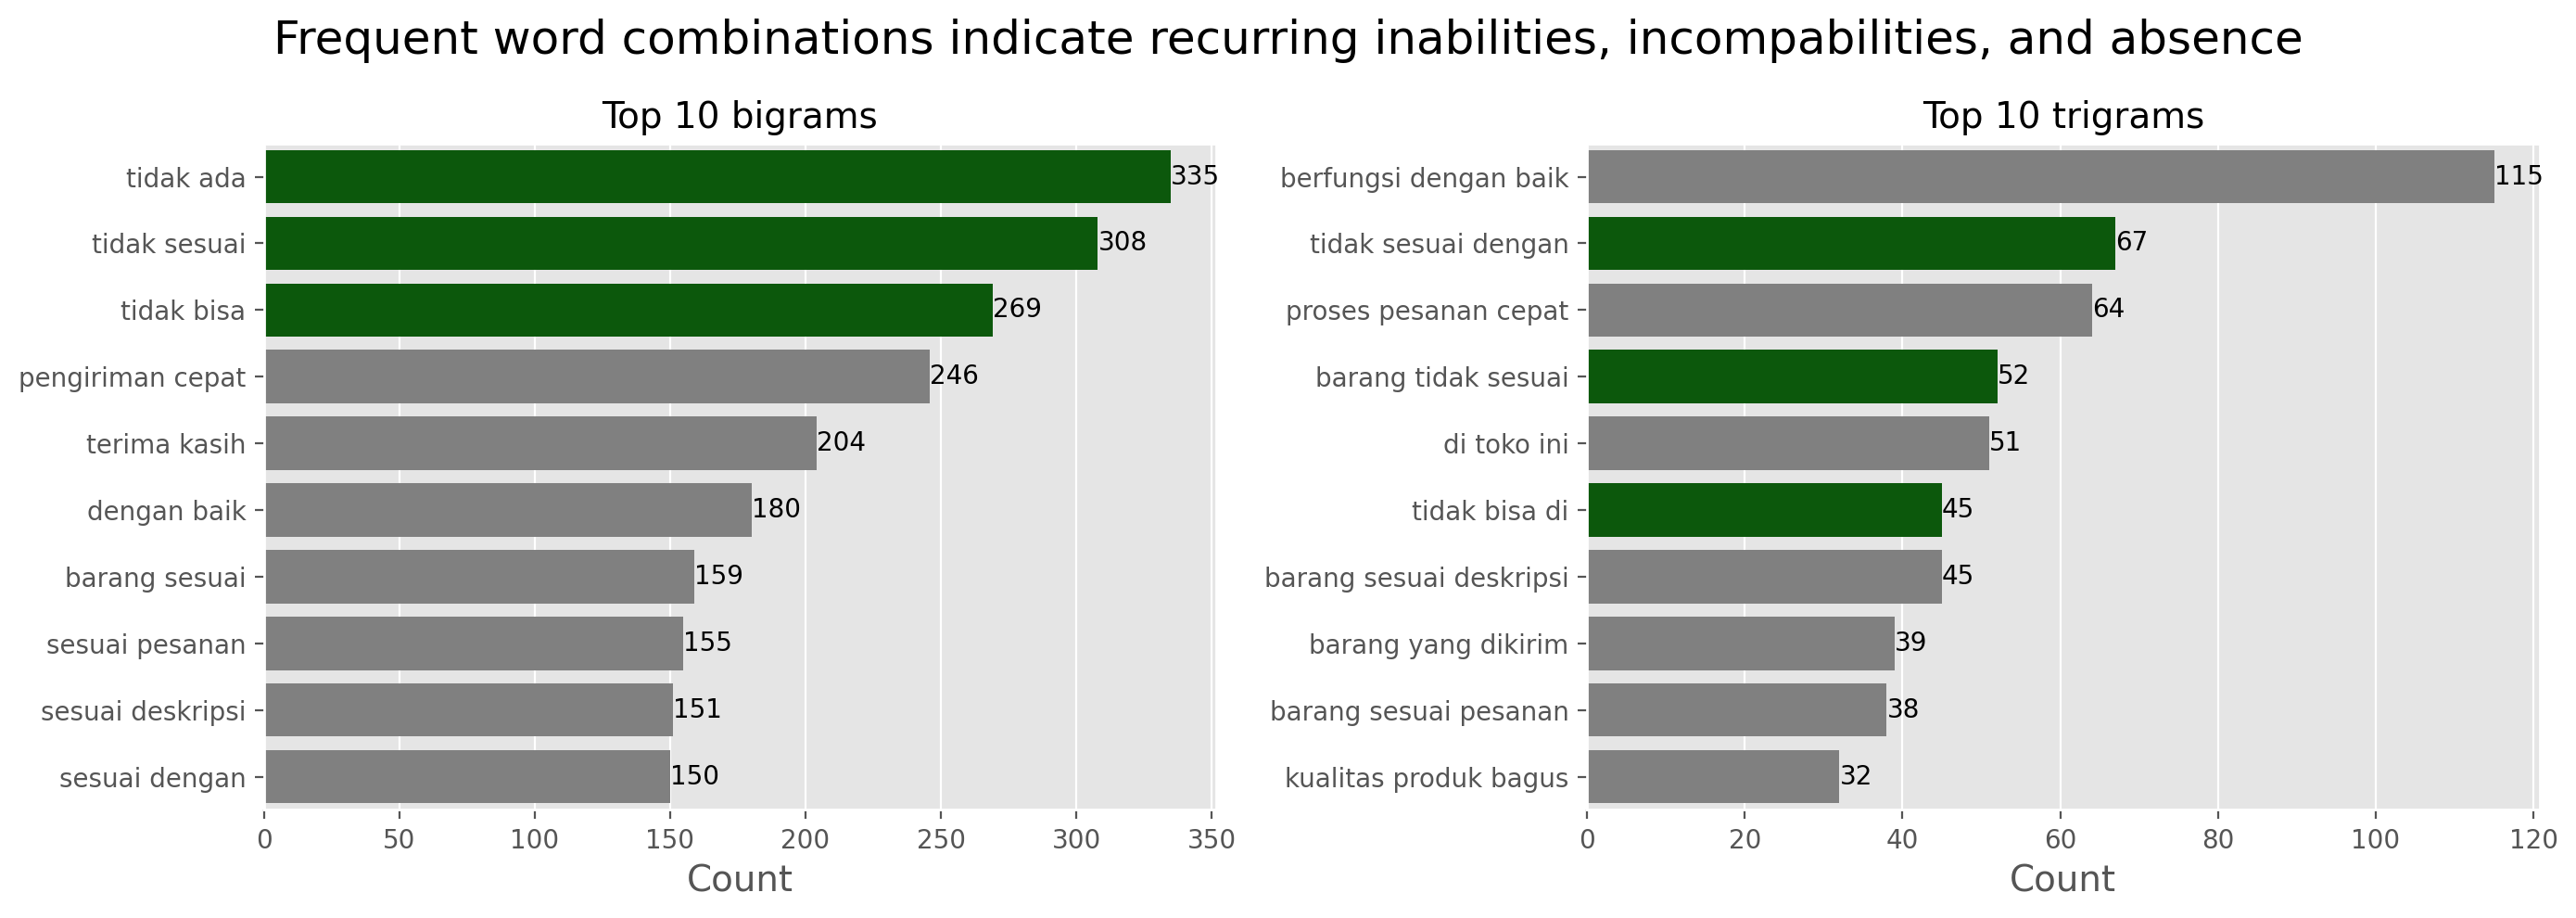

In [273]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=200)

# Define the phrases to highlight
highlight_bigrams = ['tidak bisa', 'tidak sesuai', 'tidak ada']
highlight_trigrams = ['tidak sesuai dengan', 'barang tidak sesuai', 'tidak bisa di']

# Plot for bigrams
sns.barplot(x='count', y='ngram', data=bigram_df.head(10),
            ax=axes[0], palette=['darkgreen' if ngram in highlight_bigrams 
                                 else 'grey' for ngram in bigram_df.head(10)['ngram']])
for index, value in enumerate(bigram_df.head(10)['count']):
    axes[0].text(value, index, str(value), va='center')
axes[0].set_title('Top 10 bigrams', fontsize=14)
axes[0].set_xlabel('Count', fontsize=14)
axes[0].set_ylabel(None, fontsize=14)

# Plot for trigrams
sns.barplot(x='count', y='ngram', data=trigram_df.head(10),
            ax=axes[1], palette=['darkgreen' if ngram in highlight_trigrams 
                                 else 'grey' for ngram in trigram_df.head(10)['ngram']])
for index, value in enumerate(trigram_df.head(10)['count']):
    axes[1].text(value, index, str(value), va='center')
axes[1].set_title('Top 10 trigrams', fontsize=14)
axes[1].set_xlabel('Count', fontsize=14)
axes[1].set_ylabel(None, fontsize=14)

plt.suptitle('Frequent word combinations indicate recurring inabilities, incompabilities, and absence', 
             size=18)
plt.tight_layout()
plt.show()